In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# A class created to analyse this tipe of data (uses anndata storege type that mimics phyloseq)
from utils.class_Stastics import Stastics as sc
import numpy as np
from sklearn.utils import resample
from utils import Ancova_analysis
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Charge data
files = os.listdir("data/phyloseq_data")

otu,meta, tax = [pd.read_csv("data/phyloseq_data/" + file,index_col=0) for file in files ]
otu.sum(axis=1).describe()

count      177.000000
mean     54184.858757
std       9651.908704
min      27963.000000
25%      52142.000000
50%      55103.000000
75%      57786.000000
max      83020.000000
dtype: float64

In [3]:
bql = sc(data=otu,metadata=meta)
bql.adata.var=tax
# Filter out unsassigned ASVS
bql.adata = bql.adata[:,(bql.adata.var.Unassigned==False),]
bql.adata.obs["Depth"] = bql.adata.to_df().sum(axis=1)
bql.adata

AnnData object with n_obs × n_vars = 177 × 5099
    obs: 'Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus', 'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age', 'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy', 'Passive smoking', 'Wheezing treatment', 'Wheezing count', 'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section', 'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen', 'Hospital stay (days)', 'Wheezing high frequency', 'Age_older', 'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth'
    var: 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Unassigned'
    uns: 'Description_All'

In [4]:
def rarefy_counts(df, depth):
    def rarefy_row(row):
        # Repite cada taxón según su conteo y realiza muestreo aleatorio
        expanded = np.repeat(row.index, row.values)
        rarefied = resample(expanded, n_samples=depth, replace=False, random_state=42)
        return pd.Series(rarefied).value_counts().reindex(row.index, fill_value=0)
    
    # Aplica rarefacción a cada fila
    return df.apply(rarefy_row, axis=1)

min_depth = bql.adata.obs["Depth"].min()
print(min_depth)
rarefied_df = rarefy_counts(bql.adata.to_df(), depth=int(min_depth))
# Rarefaction of counts to 27963
rarefied_df

27963.0


#OTU_num,ASV0,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,...,ASV5392,ASV5393,ASV5396,ASV5397,ASV5399,ASV5402,ASV5404,ASV5406,ASV5407,ASV5408
BQLHLP100ANF,4927,0,0,485,47,0,0,2779,0,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP100GUT,0,0,12404,0,0,0,0,131,5410,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP101ANF,3683,0,0,69,0,0,0,10,0,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP101GUT,0,0,152,0,0,1056,158,0,1080,0,...,0,0,0,0,0,0,0,0,0,0
BQLHLP102ANF,9323,16731,0,177,196,0,0,620,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HULP69GUT,0,0,2990,0,0,2533,429,0,980,0,...,0,0,0,0,0,0,0,0,0,0
HULP70ANF,128,0,10,26532,0,0,51,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HULP70GUT,0,0,0,0,0,0,16185,16,6333,0,...,0,0,0,0,0,0,0,0,0,0
HULP71ANF,0,0,16676,1,0,0,5054,10,1960,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Save the rarefy counts
bql.adata.X=rarefied_df.to_numpy()

# Calculate the alpha and beta diversity indexes

In [6]:
bql.calc_alpha_div(level="Genus",name="Shannon_index")
bql.calc_beta_div()
os.makedirs("Beta_div",exist_ok=True)
os.makedirs("Beta_div/Distances",exist_ok=True)
bql.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix.csv")
bql.adata.obsm["Distance_matrix"].head()

Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix


,BQLHLP100ANF,BQLHLP100GUT,BQLHLP101ANF,BQLHLP101GUT,BQLHLP102ANF,BQLHLP102GUT,BQLHLP103ANF,BQLHLP103GUT,BQLHLP104ANF,BQLHLP104GUT,...,HULP66GUT,HULP67ANF,HULP68ANF,HULP68GUT,HULP69ANF,HULP69GUT,HULP70ANF,HULP70GUT,HULP71ANF,HULP71GUT
BQLHLP100ANF,0.000000,0.993277,0.815792,0.999821,0.793334,0.996245,0.697529,0.999678,0.893896,0.998856,...,0.999249,0.803741,0.790938,0.992776,0.796803,0.993885,0.976862,0.998391,0.999499,0.977363
BQLHLP100GUT,0.993277,0.000000,0.999571,0.934628,0.995315,0.909201,0.991703,0.493259,0.992240,0.979830,...,0.968065,0.996388,0.990416,0.770268,0.995136,0.806387,0.998927,0.779780,0.463541,0.995709
BQLHLP101ANF,0.815792,0.999571,0.000000,0.999928,0.865358,0.999571,0.884633,0.999928,0.997103,0.999714,...,0.999678,0.865394,0.864964,0.999571,0.865107,0.999928,0.991918,0.999571,0.999535,0.994743
BQLHLP101GUT,0.999821,0.934628,0.999928,0.000000,0.999213,0.963523,0.998176,0.889103,0.999034,0.770447,...,0.946501,0.995995,0.996317,0.894682,0.998927,0.807889,0.997282,0.900404,0.859135,0.998176
BQLHLP102ANF,0.793334,0.995315,0.865358,0.999213,0.000000,0.995351,0.836033,0.999642,0.965168,0.999034,...,0.999070,0.665701,0.640132,0.996102,0.646140,0.999070,0.988842,0.999356,0.998927,0.988556


# Split the data by sample source and case control

In [7]:
bql_anf = bql.filter(var_name="Sample_Type",subgroup=["ANF"],in_place=False)
bql_anf.adata

AnnData object with n_obs × n_vars = 90 × 5099
    obs: 'Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus', 'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age', 'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy', 'Passive smoking', 'Wheezing treatment', 'Wheezing count', 'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section', 'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen', 'Hospital stay (days)', 'Wheezing high frequency', 'Age_older', 'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth', 'Shannon_index_level_Genus'
    var: 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Unassigned'
    uns: 'Description_All', 'PCoA_exp_var'
    obsm: 'PCoA', 'Distance_matrix'

In [8]:
bql_gut = bql.filter(var_name="Sample_Type",subgroup=["GUT"],in_place=False)
bql_gut.adata

AnnData object with n_obs × n_vars = 87 × 5099
    obs: 'Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus', 'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age', 'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy', 'Passive smoking', 'Wheezing treatment', 'Wheezing count', 'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section', 'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen', 'Hospital stay (days)', 'Wheezing high frequency', 'Age_older', 'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth', 'Shannon_index_level_Genus'
    var: 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Unassigned'
    uns: 'Description_All', 'PCoA_exp_var'
    obsm: 'PCoA', 'Distance_matrix'

In [9]:
# Filter out control data
bql_anf_brq = bql_anf.filter(var_name="Bronchiolitis",subgroup=["Yes"],in_place=False)
bql_gut_brq = bql_gut.filter(var_name="Bronchiolitis",subgroup=["Yes"],in_place=False)

# Figures

In [10]:
# Create the figures directory
os.makedirs("./Figures",exist_ok=True)

## Figure 1

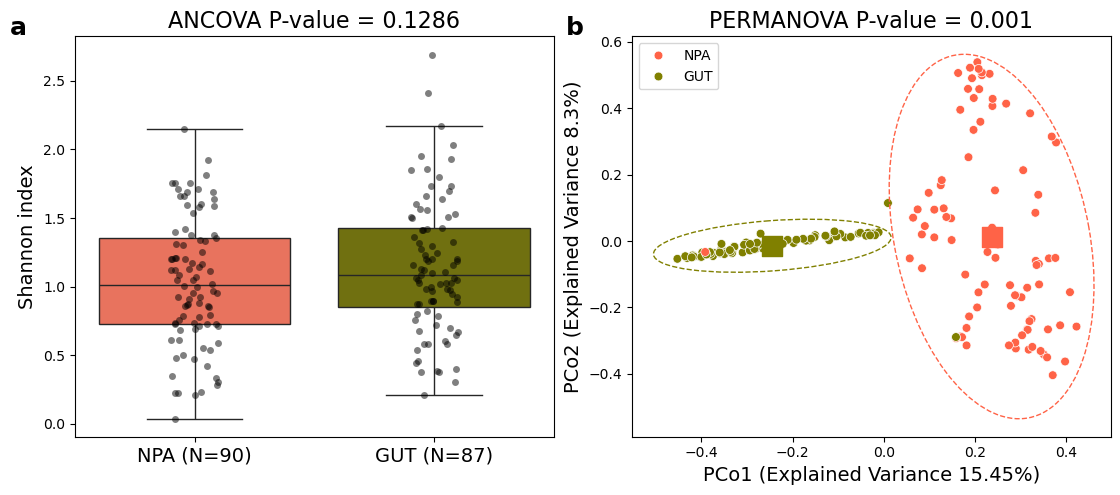

In [11]:
fig,axS = plt.subplots(1,2,figsize=(12,5))

df = bql.find_var(['Shannon_index_level_Genus',"Sample_Type",
                       "Age"]).sort_index()

df.replace({"Sample_Type":{"ANF":"NPA","GUT":"GUT"}},inplace=True)
stype_palette = {"GUT":"olive","NPA":"tomato"}
res, df_anc, ph, ax3 = Ancova_analysis.do_ancova(df,categories=1, plot=True,  ax=axS[0], palette=stype_palette)
ax3.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax3.set_ylabel("Shannon index", fontsize=14)
ax3.set_xticklabels(["NPA (N=90)","GUT (N=87)"],fontsize=14)

df_anc.sort_values(by="PR(>F)", ascending=False)

# Start with the Fig 1 B , beta div
bql.adata.obs["Sample_Type"]= bql.adata.obs["Sample_Type"].replace({"ANF":"NPA","GUT":"GUT"})

bql.plot_pcoa(obsm_key="PCoA",condition_name="Sample_Type",show=False,exp_var=bql.adata.uns["PCoA_exp_var"],
               ax=axS[1],palette=stype_palette)

axS[1].set_title(f"PERMANOVA P-value = 0.001", fontsize=16)
axS[1].set_xlabel(axS[1].get_xlabel(), fontsize=14)
axS[1].set_ylabel(axS[1].get_ylabel(), fontsize=14)
axS[1].legend()

# Add annotations for subplots
axS[0].text(-0.1, 1.05, "a", transform=axS[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[1].text(-0.1, 1.05, "b", transform=axS[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

plt.savefig("Figures/FIGURE_1.svg", bbox_inches="tight")
plt.show()



# Figure 2

Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix
Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix


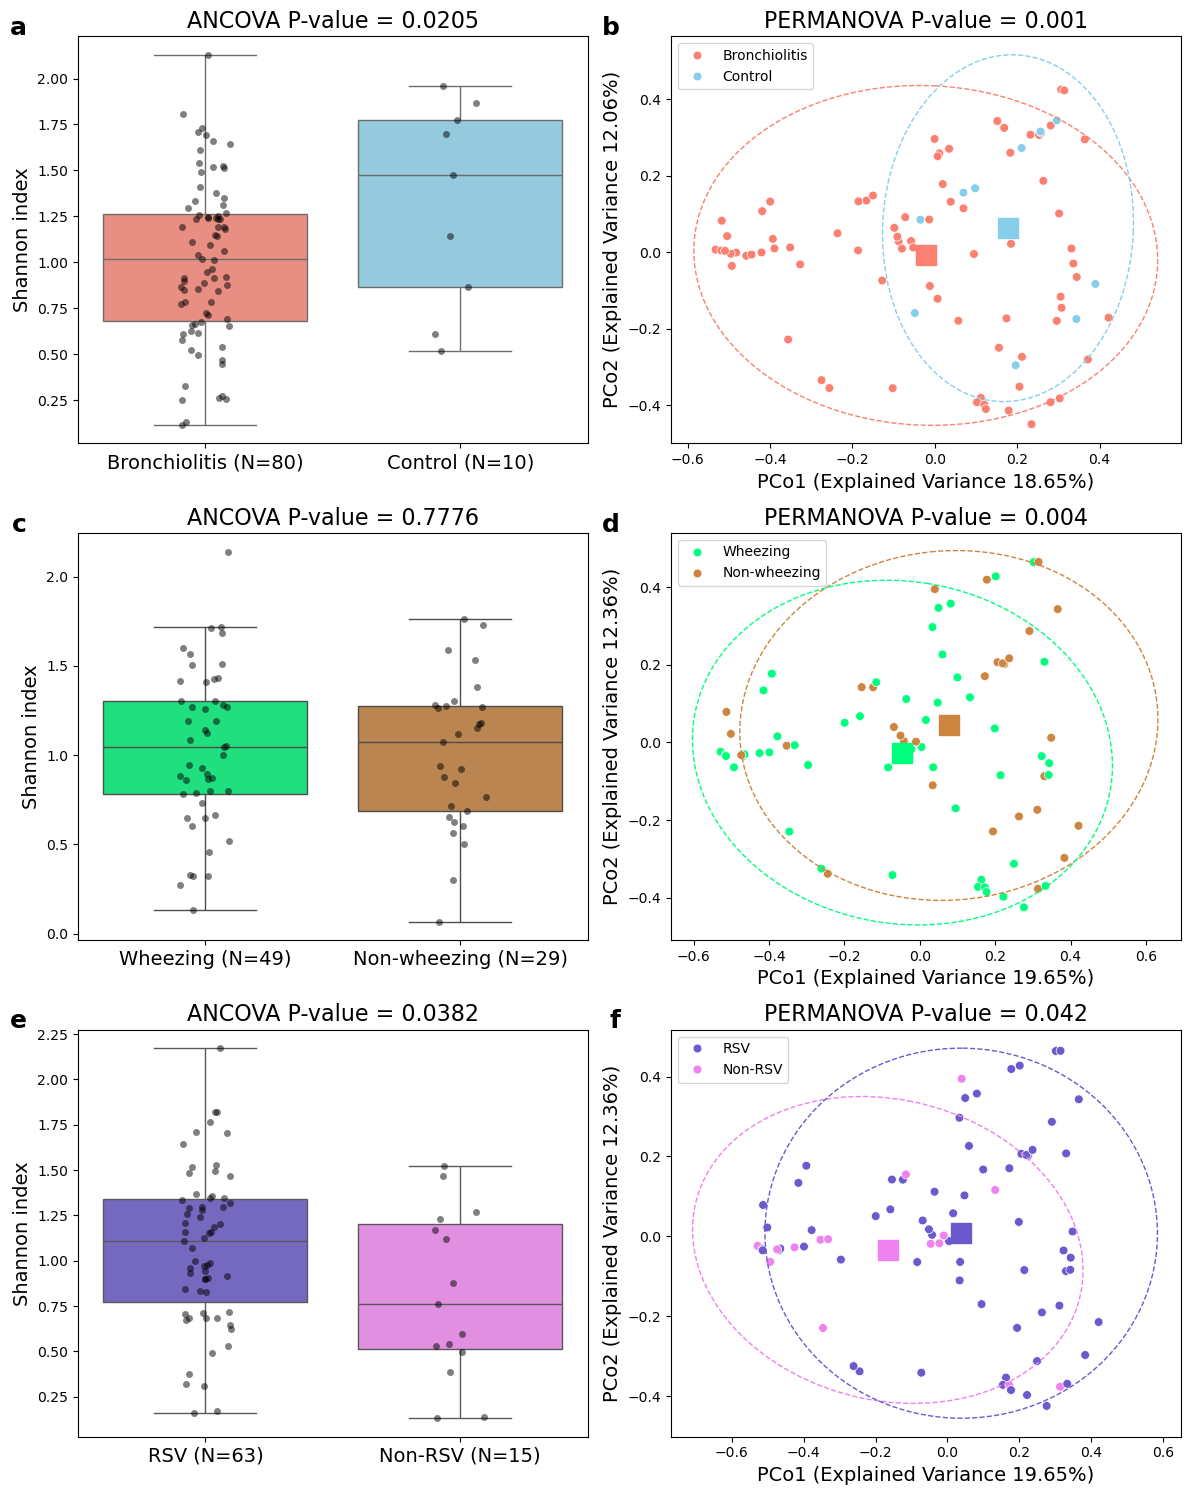

In [12]:
bql_anf.calc_beta_div()
bql_anf.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_ANF.csv")

bql_anf_brq.calc_beta_div()
bql_anf_brq.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_ANF_BRQ.csv")


fig,axS = plt.subplots(3,2,figsize=(12,15))

axS = axS.flatten()
# Start with the Fig 2 B , beta div
palette = {"Bronchiolitis":"salmon","Control":"Skyblue"}
bql_anf.adata.obs["Bronchiolitis"]= bql_anf.adata.obs["Bronchiolitis"].replace({"Yes":"Bronchiolitis","No":"Control"})


df = bql_anf.find_var(['Shannon_index_level_Genus','Bronchiolitis',  "Respiratory syncytial virus",
                       "Wheezing treatment",'Family history atopy','Breastfeeding', 'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=6, plot=True,  ax=axS[0], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Bronchiolitis (N=80)","Control (N=10)"],fontsize=14)


# Start with the Fig 1 B , beta div
bql_anf.plot_pcoa(obsm_key="PCoA",condition_name="Bronchiolitis",show=False,exp_var=bql_anf.adata.uns["PCoA_exp_var"],
               ax=axS[1],palette=palette)

axS[1].set_title(f"PERMANOVA P-value = 0.001", fontsize=16)
axS[1].set_xlabel(axS[1].get_xlabel(), fontsize=14)
axS[1].set_ylabel(axS[1].get_ylabel(), fontsize=14)
axS[1].legend()

# Add annotations for subplots
axS[0].text(-0.1, 1.05, "a", transform=axS[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[1].text(-0.1, 1.05, "b", transform=axS[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

###################

# FIGURAS 2.C Y 2. D 

###################


# Start with the Fig 2 B , beta div
palette = {"Wheezing":"springgreen","Non-wheezing":"peru"}
bql_anf_brq.adata.obs["Wheezing treatment"]= bql_anf_brq.adata.obs["Wheezing treatment"].replace({"Yes":"Wheezing","No":"Non-wheezing"})


df = bql_anf_brq.find_var(['Shannon_index_level_Genus', "Wheezing treatment",  "Respiratory syncytial virus",
                      'Family history atopy','Breastfeeding', 'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=5, plot=True,  ax=axS[2], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Wheezing (N=49)","Non-wheezing (N=29)"],fontsize=14)


# Start with the Fig 1 B , beta div
bql_anf_brq.plot_pcoa(obsm_key="PCoA",condition_name="Wheezing treatment",show=False,exp_var=bql_anf_brq.adata.uns["PCoA_exp_var"],
               ax=axS[3],palette=palette)

axS[3].set_title(f"PERMANOVA P-value = 0.004", fontsize=16)
axS[3].set_xlabel(axS[3].get_xlabel(), fontsize=14)
axS[3].set_ylabel(axS[3].get_ylabel(), fontsize=14)
axS[3].legend()

# Add annotations for subplots
axS[2].text(-0.1, 1.05, "c", transform=axS[2].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[3].text(-0.1, 1.05, "d", transform=axS[3].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

###################

# FIGURAS 2.E Y 2. F 

###################


# Start with the Fig 2 B , beta div
palette = {"RSV":"slateblue","Non-RSV":"violet"}
bql_anf_brq.adata.obs["Respiratory syncytial virus"]= bql_anf_brq.adata.obs["Respiratory syncytial virus"].replace({"Yes":"RSV","No":"Non-RSV"})


df = bql_anf_brq.find_var(['Shannon_index_level_Genus', "Respiratory syncytial virus",  "Wheezing treatment",
                      'Family history atopy','Breastfeeding', 'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=5, plot=True,  ax=axS[4], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["RSV (N=63)","Non-RSV (N=15)"],fontsize=14)

# Start with the Fig 1 B , beta div
bql_anf_brq.plot_pcoa(obsm_key="PCoA",condition_name="Respiratory syncytial virus",show=False,exp_var=bql_anf_brq.adata.uns["PCoA_exp_var"],
               ax=axS[5],palette=palette)

axS[5].set_title(f"PERMANOVA P-value = 0.042", fontsize=16)
axS[5].set_xlabel(axS[5].get_xlabel(), fontsize=14)
axS[5].set_ylabel(axS[5].get_ylabel(), fontsize=14)
axS[5].legend()

# Add annotations for subplots
axS[4].text(-0.1, 1.05, "e", transform=axS[4].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[5].text(-0.1, 1.05, "f", transform=axS[5].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')



plt.savefig("Figures/FIGURE_2.svg", bbox_inches="tight")
plt.show()

# Figure 3

Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix
Saving PCoA and Distance matrix in obsm as: PCoA and Distance_matrix


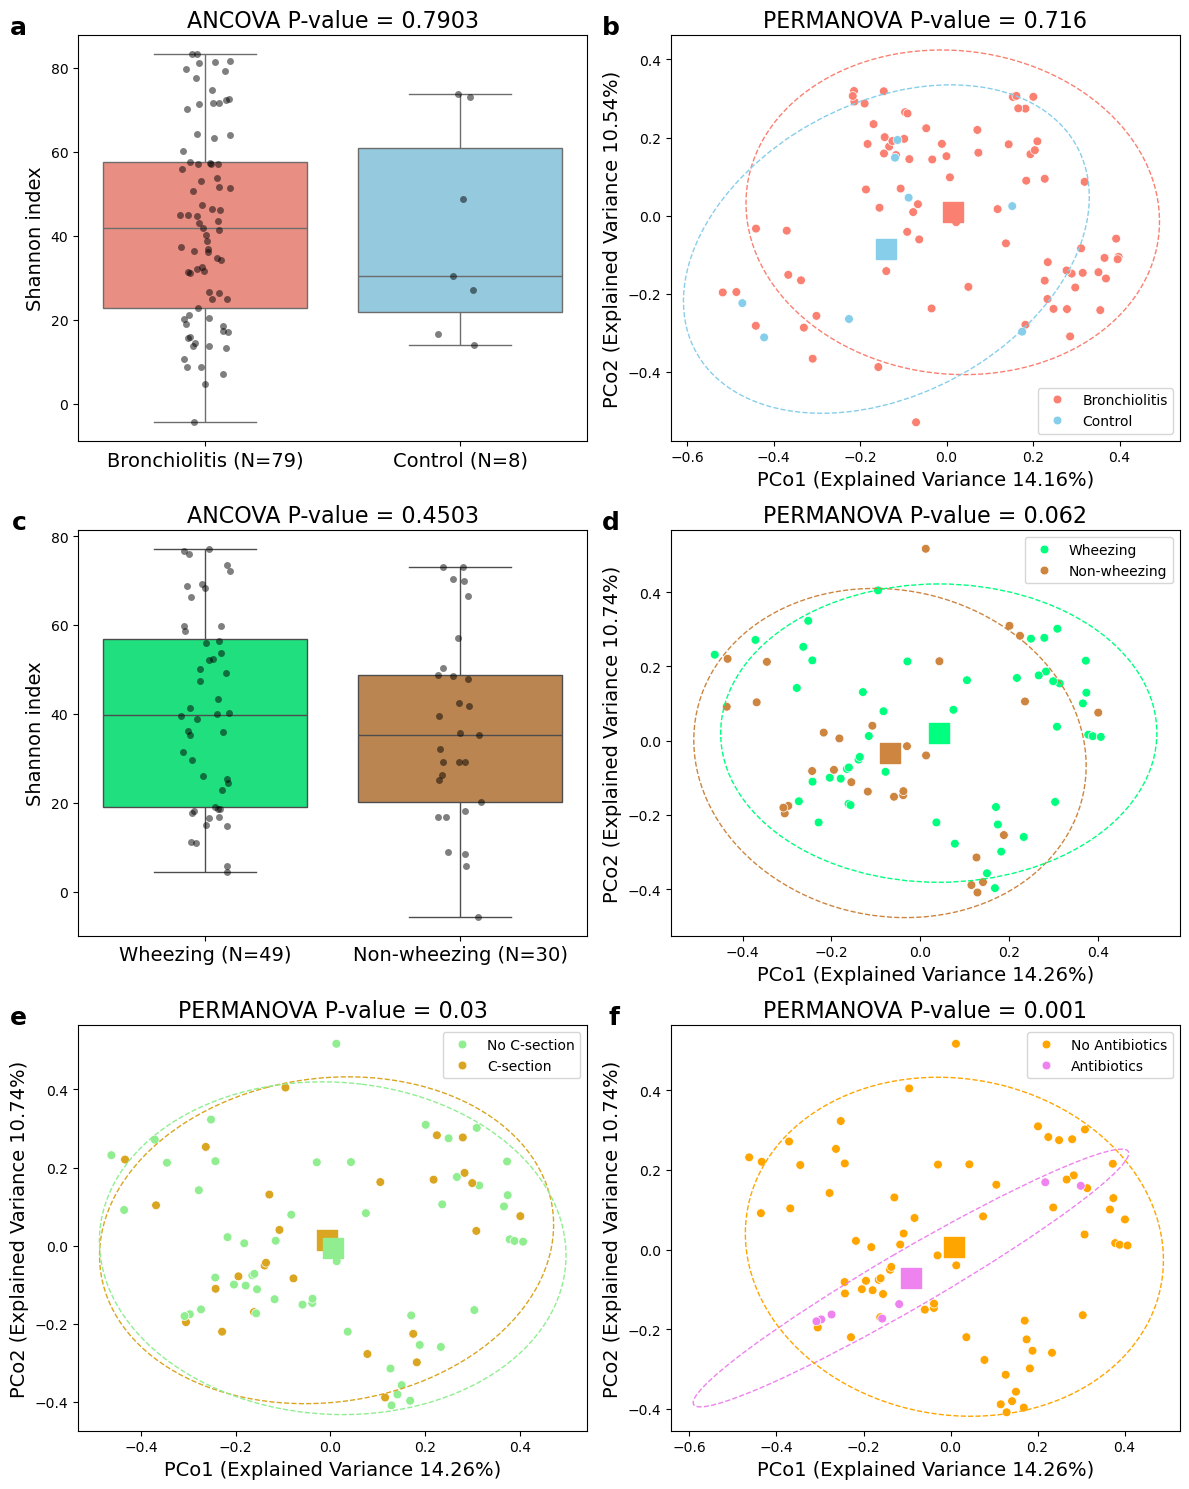

In [13]:
bql_gut.calc_beta_div()
bql_gut.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_GUT.csv")

bql_gut_brq.calc_beta_div()
bql_gut_brq.adata.obsm["Distance_matrix"].to_csv("Beta_div/Distances/Distance_matrix_GUT_BRQ.csv")


fig,axS = plt.subplots(3,2,figsize=(12,15))
axS = axS.flatten()

# Start with the Fig 2 B , beta div
palette = {"Bronchiolitis":"salmon","Control":"Skyblue"}
bql_gut.adata.obs["Bronchiolitis"]= bql_gut.adata.obs["Bronchiolitis"].replace({"Yes":"Bronchiolitis","No":"Control"})


df = bql_gut.find_var(['Shannon_index_level_Genus','Bronchiolitis',  "Respiratory syncytial virus",
                       "Wheezing treatment",'Family history atopy','Breastfeeding', 'Cesarean section',"Previous antibiotics",'Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=7, plot=True,  ax=axS[0], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Bronchiolitis (N=79)","Control (N=8)"],fontsize=14)

# Start with the Fig 1 B , beta div
bql_gut.plot_pcoa(obsm_key="PCoA",condition_name="Bronchiolitis",show=False,exp_var=bql_gut.adata.uns["PCoA_exp_var"],
               ax=axS[1],palette=palette)

axS[1].set_title(f"PERMANOVA P-value = 0.716", fontsize=16)
axS[1].set_xlabel(axS[1].get_xlabel(), fontsize=14)
axS[1].set_ylabel(axS[1].get_ylabel(), fontsize=14)
axS[1].legend()

# Add annotations for subplots
axS[0].text(-0.1, 1.05, "a", transform=axS[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[1].text(-0.1, 1.05, "b", transform=axS[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')



###################

# FIGURAS 3.C Y 3.D 

###################



# Start with the Fig 2 B , beta div
palette = {"Wheezing":"springgreen","Non-wheezing":"peru"}
bql_gut_brq.adata.obs["Wheezing treatment"]= bql_gut_brq.adata.obs["Wheezing treatment"].replace({"Yes":"Wheezing","No":"Non-wheezing"})


df = bql_gut_brq.find_var(['Shannon_index_level_Genus', "Wheezing treatment",  "Respiratory syncytial virus",
                      'Family history atopy','Breastfeeding', "Previous antibiotics",'Cesarean section','Age' ]).sort_index().dropna()


res, df_anc, ph, ax1 = Ancova_analysis.do_ancova(df,categories=6, plot=True,  ax=axS[2], palette=palette)
ax1.set_title(f"ANCOVA P-value = {res['P.val (Categorical condition)'].values[0]}", fontsize=16)
ax1.set_ylabel("Shannon index", fontsize=14)
ax1.set_xticklabels(["Wheezing (N=49)","Non-wheezing (N=30)"],fontsize=14)

# Start with the Fig 1 B , beta div
bql_gut_brq.plot_pcoa(obsm_key="PCoA",condition_name="Wheezing treatment",show=False,exp_var=bql_gut_brq.adata.uns["PCoA_exp_var"],
               ax=axS[3],palette=palette)

axS[3].set_title(f"PERMANOVA P-value = 0.062", fontsize=16)
axS[3].set_xlabel(axS[3].get_xlabel(), fontsize=14)
axS[3].set_ylabel(axS[3].get_ylabel(), fontsize=14)
axS[3].legend()

# Add annotations for subplots
axS[2].text(-0.1, 1.05, "c", transform=axS[2].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[3].text(-0.1, 1.05, "d", transform=axS[3].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')




###################

# FIGURAS 3.E Y 3.F 

###################


# Start with the Fig 2 B , beta div
palette = {"Antibiotics":"violet","No Antibiotics":"orange"}
bql_gut_brq.adata.obs["Previous antibiotics"]= bql_gut_brq.adata.obs["Previous antibiotics"].replace({"Yes":"Antibiotics","No":"No Antibiotics"})

palette_2 = {"C-section":"goldenrod","No C-section":"lightgreen"}

bql_gut_brq.adata.obs["Cesarean section"]= bql_gut_brq.adata.obs["Cesarean section"].replace({"Yes":"C-section","No":"No C-section"})

# Start with the Fig 1 B , beta div
bql_gut_brq.plot_pcoa(obsm_key="PCoA",condition_name="Cesarean section",show=False,exp_var=bql_gut_brq.adata.uns["PCoA_exp_var"],
               ax=axS[4],palette=palette_2)

axS[4].set_title(f"PERMANOVA P-value = 0.03", fontsize=16)
axS[4].set_xlabel(axS[4].get_xlabel(), fontsize=14)
axS[4].set_ylabel(axS[4].get_ylabel(), fontsize=14)
axS[4].legend()

# Start with the Fig 1 B , beta div
bql_gut_brq.plot_pcoa(obsm_key="PCoA",condition_name="Previous antibiotics",show=False,exp_var=bql_gut_brq.adata.uns["PCoA_exp_var"],
               ax=axS[5],palette=palette)

axS[5].set_title(f"PERMANOVA P-value = 0.001", fontsize=16)
axS[5].set_xlabel(axS[5].get_xlabel(), fontsize=14)
axS[5].set_ylabel(axS[5].get_ylabel(), fontsize=14)
axS[5].legend()

# Add annotations for subplots
axS[4].text(-0.1, 1.05, "e", transform=axS[4].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axS[5].text(-0.1, 1.05, "f", transform=axS[5].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')



plt.savefig("Figures/FIGURE_3.svg", bbox_inches="tight")
plt.show()

# Figure 4

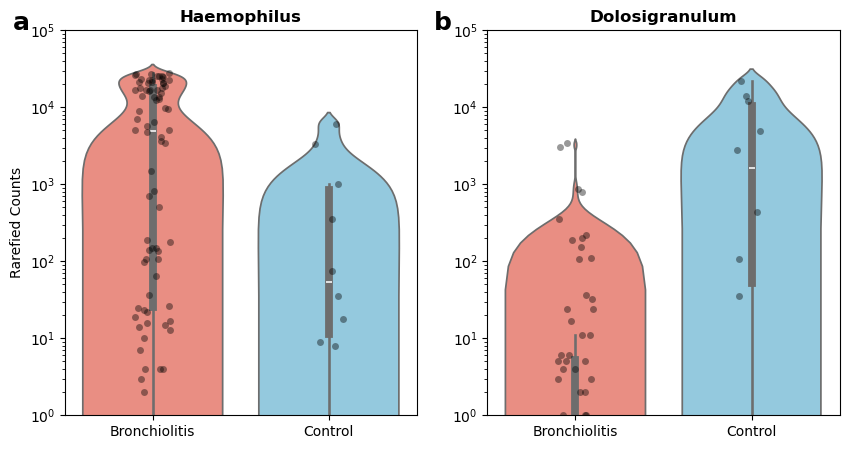

In [14]:
df_genus = pd.DataFrame(bql_anf.adata.X,index=bql_anf.adata.obs_names,columns=bql_anf.adata.var.Genus)

# Extract dataframes with the bacterial genus counts
haemophilus=df_genus["Haemophilus"].sum(axis=1).to_frame().rename(columns={0:"Haemophilus"})
haemophilus["Bronchiolitis"] = haemophilus.index.map(bql_anf.adata.obs.Bronchiolitis.to_dict())
haemophilus["Bronchiolitis"].replace({"Yes":"Bronchiolitis", "No":"Control"},inplace=True)

dolosigranulum=df_genus["Dolosigranulum"].sum(axis=1).to_frame().rename(columns={0:"Dolosigranulum"})
dolosigranulum["Bronchiolitis"] = dolosigranulum.index.map(bql_anf.adata.obs.Bronchiolitis.to_dict())
dolosigranulum["Bronchiolitis"].replace({"Yes":"Bronchiolitis", "No":"Control"},inplace=True)

fig,axs= plt.subplots(1,2,figsize=(10,5))
# Define the palette
palette={"Bronchiolitis": "salmon", "Control": "skyblue"}


# PLot haemophilus
sns.violinplot(
        data=haemophilus,
        y="Haemophilus",
        x="Bronchiolitis",     
        palette=palette,ax=axs[0])

sns.stripplot(
        data=haemophilus,
        y="Haemophilus",
        x="Bronchiolitis",  color="black" ,alpha=0.4 ,ax=axs[0])

axs[0].set_xlabel("")
axs[0].set_ylabel("Rarefied Counts")
axs[0].set_title("Haemophilus",fontweight=900)
axs[0].set_yscale("log")
axs[0].set_ylim([1,100000])


# Plot Dolosigranulum
sns.violinplot(
        data=dolosigranulum,
        y="Dolosigranulum",
        x="Bronchiolitis",     
        palette=palette,ax=axs[1])

sns.stripplot(
        data=dolosigranulum,
        y="Dolosigranulum",
        x="Bronchiolitis",  color="black" ,alpha=0.4 ,ax=axs[1])

axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].set_title("Dolosigranulum",fontweight=900)
axs[1].set_yscale("log")
axs[1].set_ylim([1,100000])

# Add annotations for subplots
axs[0].text(-0.1, 1.05, "a", transform=axs[0].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

axs[1].text(-0.1, 1.05, "b", transform=axs[1].transAxes,
            fontsize=18, fontweight='bold', va='top', ha='right')

plt.savefig("Figures/Figure_4.svg")
plt.show()

# Lasso models to assert perdictive value

1º - Seleccionar las variables y generar las tablas.

2º - Normalizar los datos.

3º - Predicción lasso.

In [15]:

def transform_to_clr(df):
    """
    Transforms a DataFrame to CLR (Centered Log Ratio) transformation.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with compositional data
    
    Returns:
    pd.DataFrame: DataFrame transformed with CLR
    """
    
    def relab(row):
        """Helper function to relativize the data"""
        row1 = row.copy()
        total = row1.sum()
        row1[row1 != 0] = row1[row1 != 0] / total
        return row1
    
    # Step 1: Relativize the data
    rel_df = df.apply(relab, axis=1)
    
    # Step 2: Calculate pseudocount
    pseudocount = rel_df[rel_df > 0].min().min() / 100
    
    # Step 3: Convert to numpy array and add pseudocount
    data_clr = rel_df.to_numpy(float)
    data_clr += pseudocount
    
    # Step 4: Calculate geometric mean across rows
    geometric_mean = np.exp(np.mean(np.log(data_clr), axis=1, keepdims=True))
    
    # Step 5: Apply CLR transformation
    clr_transformed = np.log(data_clr / geometric_mean)
    
    # Step 6: Convert back to DataFrame
    clr_df = pd.DataFrame(clr_transformed, 
                         columns=df.columns, 
                         index=df.index)
    
    return clr_df

# Usage example:
# clr_transformed = transform_to_clr(df)

In [16]:
bql_anf.adata.obs.columns

Index(['Bronchiolitis', 'Virus', 'Co-infection', 'Rhinovirus',
       'Respiratory syncytial virus', 'Other Viruses', 'Sex (Male)', 'Age',
       'Breastfeeding', 'Breastfeeding Duration', 'Family history atopy',
       'Passive smoking', 'Wheezing treatment', 'Wheezing count',
       'Respiratory hospitalization', 'Asthma treatment', 'Cesarean section',
       'Previous antibiotics', 'Fever', 'Hypoxia', 'ICU / High-flow oxygen',
       'Hospital stay (days)', 'Wheezing high frequency', 'Age_older',
       'Sample_Type', 'Has_pet', 'Pet_type', 'Has_dog', 'Has_cat', 'Depth',
       'Shannon_index_level_Genus'],
      dtype='object')

# Extract microbiome data

# SEGUIR TRABAJANDO EN ESTO!!

In [17]:
from bootstrap_laso.model_bootstrap import BootstrapLassoRunner



# Extract genus
diff_abundances = pd.read_csv("./Abundances/ANF_BQL_ANCOMBC2.csv",index_col=0)

dif_genus = diff_abundances.loc[(abs(diff_abundances['lfc_BronchiolitisYes'])>1) & (diff_abundances['q_BronchiolitisYes'] <0.05) ].taxon.map(lambda x: x.split(":")[1] if x.split(":")[0]!="Family" else "")

sel_genus = dif_genus.loc[dif_genus!=""].tolist()

# EXTRACT THE SIGNIFICANT GENUS AGREGGATED COUNTS
df_genus = pd.DataFrame(bql_anf.adata.X[:,bql_anf.adata.var.Genus.map(lambda x: x in sel_genus)],index=bql_anf.adata.obs_names).T
df_genus["Genus"] = bql_anf.adata.var.Genus[bql_anf.adata.var.Genus.map(lambda x: x in sel_genus)].tolist()
df_genus = df_genus.groupby("Genus").sum().T


# Categorical → binarized
variables = []
cat_vars = ['Bronchiolitis',"Wheezing treatment",'Respiratory syncytial virus',
            'Breastfeeding', 'Cesarean section','Family history atopy']

for var in cat_vars:
    variable = bql_anf.make_dummy(var).astype(int)
    variables.append(variable[variable.columns[0]])

categorical_covars = pd.concat(variables,axis=1)

# Continuous covariate
covariables = pd.concat([categorical_covars, bql_anf.adata.obs[['Age']]], axis=1)

# Combine CLR microbiota + covariates
X = pd.concat([df_genus, covariables], axis=1).dropna()
y = X["Bronchiolitis_Bronchiolitis"]
X = X.drop("Bronchiolitis_Bronchiolitis", axis=1)

runner = BootstrapLassoRunner(
    clr_variables=sel_genus,
    standardize_variables=sel_genus+["Age"],
    n_splits_cv=5,
)

results = runner.run_many(X, y, n_boot=500)



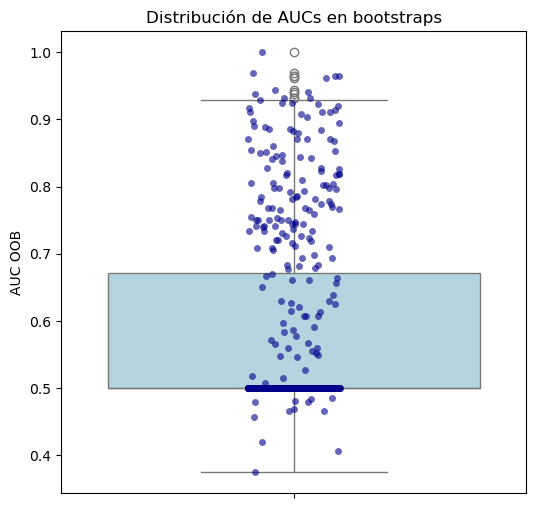

,auc,lambda,n_features_selected,intercept,n_oob,n_oob_controls
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.583623,0.080463,0.772000,0.903800,32.344000,3.476000
std,0.140079,0.016358,1.040279,0.007807,2.920741,0.898353
min,0.375000,0.042937,0.000000,0.831208,24.000000,1.000000
25%,0.500000,0.068356,0.000000,0.905882,31.000000,3.000000
50%,0.500000,0.076960,0.000000,0.905882,32.000000,3.000000
75%,0.671461,0.092303,1.000000,0.905882,34.000000,4.000000
max,1.000000,0.129029,5.000000,0.905882,40.000000,6.000000


In [18]:
results = pd.DataFrame(results)
results["n_oob_controls"] =results.oob_class_counts.map(lambda x: x[0])
plt.figure(figsize=(6,6))
sns.boxplot(y="auc", data=results, whis=1.5, color="lightblue")  # caja
sns.stripplot(y="auc", data=results, color="darkblue", alpha=0.6, jitter=True)  # puntos individuales
plt.title("Distribución de AUCs en bootstraps")
plt.ylabel("AUC OOB")
plt.show()
results.describe()


# INVESTIGA! POR QUE SALEN TANTOS 0.5 ,COMO ME LOS QUITO?

In [28]:
results.head()

,auc,model,lambda,coef,n_features_selected,Features,intercept,oob_index,n_oob,oob_class_counts,n_oob_controls,metric
0,0.500000,LassoCV(cv=5),0.092804,Anaerosinus -0.0 Arcobac...,0,"[-0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, ...",0.905882,"Index(['BQLHLP101ANF', 'BQLHLP105ANF', 'BQLHLP...",28,"{1: 24, 0: 4}",4,2.0
1,0.500000,LassoCV(cv=5),0.069303,Anaerosinus -0.0 Arcobac...,0,"[-0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, ...",0.905882,"Index(['BQLHLP101ANF', 'BQLHLP103ANF', 'BQLHLP...",31,"{1: 29, 0: 2}",2,1.0
2,0.500000,LassoCV(cv=5),0.115370,Anaerosinus 0.0 Arcobac...,0,"[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0...",0.905882,"Index(['BQLHLP103ANF', 'BQLHLP110ANF', 'BQLHLP...",32,"{1: 29, 0: 3}",3,1.5
3,0.683333,LassoCV(cv=5),0.088901,Anaerosinus 0.000000 Ar...,2,"[0.0, 0.0, 0.006422439398817615, 0.0, -9.51034...",0.905882,"Index(['BQLHLP100ANF', 'BQLHLP104ANF', 'BQLHLP...",36,"{1: 30, 0: 6}",6,4.1
4,0.500000,LassoCV(cv=5),0.066436,Anaerosinus 0.0 Arcobac...,0,"[0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0....",0.905882,"Index(['BQLHLP100ANF', 'BQLHLP104ANF', 'BQLHLP...",33,"{1: 29, 0: 4}",4,2.0


In [32]:
results["COEFS"] = results.coef.map(lambda x: "NO" if x.sum()==0 else "Yes")

,auc,lambda,n_features_selected,intercept,n_oob,n_oob_controls,metric
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.677922,0.073934,1.642553,0.901452,32.348936,3.463830,2.331177
std,0.158096,0.014256,0.933641,0.010932,2.771487,0.897391,0.773657
min,0.375000,0.042937,1.000000,0.831208,25.000000,1.000000,0.964286
25%,0.500000,0.063793,1.000000,0.905788,31.000000,3.000000,1.691138
50%,0.697917,0.071699,1.000000,0.905882,32.000000,3.000000,2.250000
75%,0.804085,0.080540,2.000000,0.905882,34.000000,4.000000,2.796552
max,1.000000,0.125741,5.000000,0.905882,38.000000,6.000000,4.844828


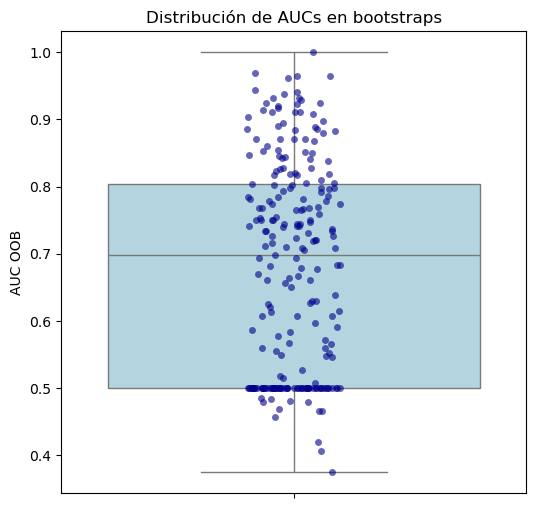

,auc,lambda,n_features_selected,intercept,n_oob,n_oob_controls,metric
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,0.677922,0.073934,1.642553,0.901452,32.348936,3.463830,2.331177
std,0.158096,0.014256,0.933641,0.010932,2.771487,0.897391,0.773657
min,0.375000,0.042937,1.000000,0.831208,25.000000,1.000000,0.964286
25%,0.500000,0.063793,1.000000,0.905788,31.000000,3.000000,1.691138
50%,0.697917,0.071699,1.000000,0.905882,32.000000,3.000000,2.250000
75%,0.804085,0.080540,2.000000,0.905882,34.000000,4.000000,2.796552
max,1.000000,0.125741,5.000000,0.905882,38.000000,6.000000,4.844828


In [35]:
results["n_oob_controls"] =results.oob_class_counts.map(lambda x: x[0])
results = results.loc[results["COEFS"]=="Yes"]
display(results.describe())
results["metric"] = results.auc*results["n_oob_controls"]
plt.figure(figsize=(6,6))
sns.boxplot(y="auc", data=results, whis=1.5, color="lightblue")  # caja
sns.stripplot(y="auc", data=results, color="darkblue", alpha=0.6, jitter=True)  # puntos individuales
plt.title("Distribución de AUCs en bootstraps")
plt.ylabel("AUC OOB")
plt.show()
results.describe()

<Axes: xlabel='auc', ylabel='n_oob_controls'>

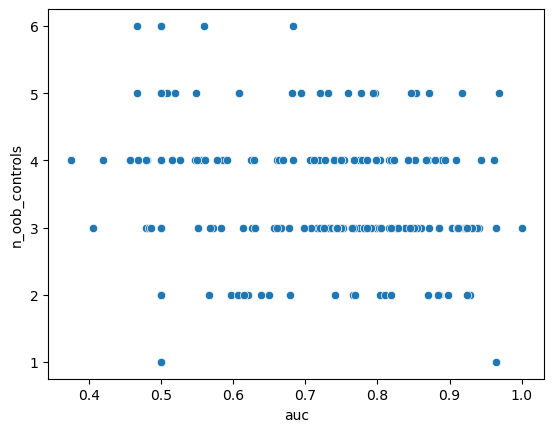

In [20]:
sns.scatterplot(data=results,y="n_oob_controls",x="auc")

In [21]:
# 1. Calcular coeficientes reales
coef_real = results[["coef"]]

# 2. Permutaciones
n_perm = 100
coef_perm_list = []

for i in range(n_perm):
    y_perm = y.sample(frac=1, replace=False).reset_index(drop=True)  # permutado
    results_perm = runner.run_many(X, y_perm, n_boot=50)  # menos bootstraps por perm para ahorrar tiempo
    coef_perm_list.append(pd.DataFrame([r["coef"] for r in results_perm]))

# 3. Combinar permutaciones
coef_null = pd.concat(coef_perm_list, axis=0)

# 4. Calcular p-values empíricos
p_values = (coef_null.abs().ge(coef_real.abs().values, axis=1).sum(axis=0) + 1) / (len(coef_null) + 1)


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

AUC FULL model: 1.0
AUC MICROBIOTA ONLY: 0.8774928774928775
AUC COVARIABLES ONLY: 0.9501424501424501


,Feature,Coef_mean,CI_lower,CI_upper,p_empirical
0,Cesarean section_No,-9.846078,-41.936754,0.676574,0.062
1,Age,-5.670848,-27.076886,-0.760487,0.026
2,Breastfeeding_Yes,-5.019072,-14.628647,9.207563,0.968
3,Macellibacteroides,-4.628802,-29.309726,-1.990422,0.004
4,Family history atopy_Yes,-2.313811,-26.237573,3.883795,0.330
5,Dolosigranulum,-2.165997,-16.154685,0.379188,0.066
6,Anaerosinus,-0.009341,-7.809072,11.171705,0.912
7,Bacteroides,0.903753,-6.383277,14.569112,0.952
8,Methanobrevibacter,1.491287,-2.218308,14.316048,0.248
9,Atopobium,2.131577,0.710958,23.111956,0.026


ValueError: 'xerr' must not contain negative values

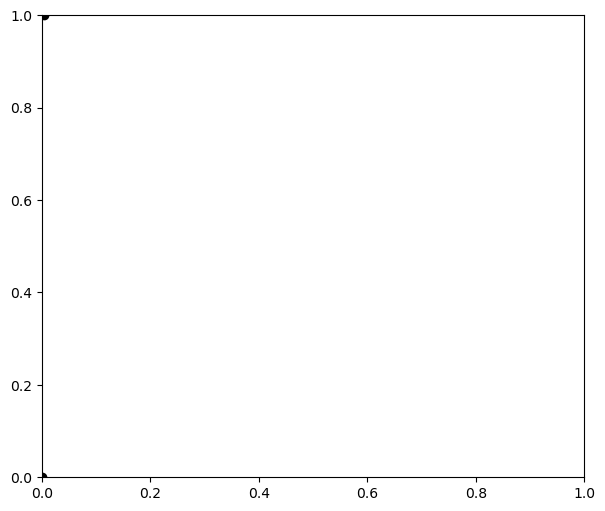

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
# Extract genus
diff_abundances = pd.read_csv("./Abundances/ANF_BQL_ANCOMBC2.csv",index_col=0)

dif_genus = diff_abundances.loc[(abs(diff_abundances['lfc_BronchiolitisYes'])>1) & (diff_abundances['q_BronchiolitisYes'] <0.05) ].taxon.map(lambda x: x.split(":")[1] if x.split(":")[0]!="Family" else "")

sel_genus = dif_genus.loc[dif_genus!=""].tolist()

# EXTRACT THE SIGNIFICANT GENUS AGREGGATED COUNTS
df_genus = pd.DataFrame(bql_anf.adata.X[:,bql_anf.adata.var.Genus.map(lambda x: x in sel_genus)],index=bql_anf.adata.obs_names).T
df_genus["Genus"] = bql_anf.adata.var.Genus[bql_anf.adata.var.Genus.map(lambda x: x in sel_genus)].tolist()
df_genus = df_genus.groupby("Genus").sum().T

clr_genus = transform_to_clr(df_genus)
# ============================
# PREPROCESSING
# ============================

# Categorical → binarized
variables = []
cat_vars = ['Bronchiolitis',"Wheezing treatment",'Respiratory syncytial virus',
            'Breastfeeding', 'Cesarean section','Family history atopy']

for var in cat_vars:
    variable = bql_anf.make_dummy(var).astype(int)
    variables.append(variable[variable.columns[0]])

categorical_covars = pd.concat(variables,axis=1)

# Continuous covariate
covariables = pd.concat([categorical_covars, bql_anf.adata.obs[['Age']]], axis=1)

# Combine CLR microbiota + covariates
X = pd.concat([clr_genus, covariables], axis=1).dropna()
y = X["Bronchiolitis_Bronchiolitis"]
X = X.drop("Bronchiolitis_Bronchiolitis", axis=1)

# Standardize continuous variables (genera + age)
cont_vars = sel_genus + ["Age"]
X[cont_vars] = StandardScaler().fit_transform(X[cont_vars])

# Split view matrices
covariate_cols = [c for c in X.columns if c not in sel_genus]
X_mic = X[sel_genus]
X_cov = X[covariate_cols]


# ============================
# LASSO WITH CROSS-VALIDATION
# ============================

def fit_lasso_model(X_in, y):
    lasso = LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        class_weight='balanced',
        max_iter=5000,
        n_jobs=-1,
        random_state=42
    )
    lasso.fit(X_in, y)
    y_proba = lasso.predict_proba(X_in)[:, 1]
    auc = roc_auc_score(y, y_proba)
    return lasso, auc, y_proba

lasso_full, auc_full, proba_full = fit_lasso_model(X, y)
lasso_mic,  auc_mic,  proba_mic  = fit_lasso_model(X_mic, y)
lasso_cov,  auc_cov,  proba_cov  = fit_lasso_model(X_cov, y)

print("AUC FULL model:", auc_full)
print("AUC MICROBIOTA ONLY:", auc_mic)
print("AUC COVARIABLES ONLY:", auc_cov)


# ============================
# VARIABLE SELECTION (LASSO)
# ============================

coef = pd.Series(lasso_full.coef_[0], index=X.columns)
nonzero = coef[coef.abs() > 1e-5].sort_values()

X_sel = X[nonzero.index]  # subset for unpenalized refit


# ============================
# BOOTSTRAP UNPENALIZED MODEL
# ============================

# Ensure consistent ordering
ordered_cols = X_sel.columns.tolist()

n_boot = 1000
coef_matrix = np.zeros((n_boot, len(ordered_cols)))

for i in range(n_boot):
    idx = np.random.choice(X_sel.index, size=len(X_sel), replace=True)
    X_boot = X_sel.loc[idx]
    y_boot = y.loc[idx]

    lr = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
    lr.fit(X_boot, y_boot)

    coef_matrix[i, :] = lr.coef_[0]

# Bootstrap summary
ci_lower = np.percentile(coef_matrix, 2.5, axis=0)
ci_upper = np.percentile(coef_matrix, 97.5, axis=0)

# Empirical p-values
p_emp = np.mean(coef_matrix > 0, axis=0)
p_emp = 2 * np.minimum(p_emp, 1 - p_emp)

df_boot = pd.DataFrame({
    "Feature": ordered_cols,
    "Coef_mean": nonzero[ordered_cols].values,
    "CI_lower": ci_lower,
    "CI_upper": ci_upper,
    "p_empirical": p_emp
})

display(df_boot)


# ============================
# FOREST PLOT (EPIDEMIOLOGY STYLE)
# ============================

# Convert to OR scale
df_plot = df_boot.copy()
df_plot["OR"] = np.exp(df_plot["Coef_mean"])
df_plot["OR_low"] = np.exp(df_plot["CI_lower"])
df_plot["OR_high"] = np.exp(df_plot["CI_upper"])

plt.figure(figsize=(7, max(4, len(df_plot)*0.5)))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    x=df_plot["OR"],
    y=y_pos,
    xerr=[df_plot["OR"] - df_plot["OR_low"],
          df_plot["OR_high"] - df_plot["OR"]],
    fmt='o',
    color='black',
    ecolor='gray',
    elinewidth=2,
    capsize=3
)

plt.axvline(1, color='red', linestyle='--', linewidth=2)
plt.yticks(y_pos, df_plot["Feature"])
plt.xlabel("Odds Ratio (95% CI)")
plt.title("Forest Plot of Logistic Regression Coefficients")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Seleccionamos sólo las variables no nulas del modelo LASSO full
coef = pd.Series(lasso_full.coef_[0], index=X.columns)
nonzero = coef[coef.abs() > 1e-5].sort_values()
X_sel = X[nonzero.index]

# -------------------------------
# Bootstrap para IC95% y p-empíricos
# -------------------------------
n_boot = 1000
coef_matrix = np.zeros((n_boot, len(nonzero)))

for i in range(n_boot):
    idx = np.random.choice(X_sel.index, size=len(X_sel), replace=True)
    X_boot = X_sel.loc[idx]
    y_boot = y.loc[idx]
    
    # Modelo sin penalización pero con regularización mínima para evitar coef gigante
    lr = LogisticRegression(penalty='l2', C=1e6, solver='lbfgs', max_iter=5000)
    lr.fit(X_boot, y_boot)
    
    coef_matrix[i,:] = lr.coef_[0]

# IC95% empírico
ci_lower = np.percentile(coef_matrix, 2.5, axis=0)
ci_upper = np.percentile(coef_matrix, 97.5, axis=0)
coef_mean = nonzero.values

# P-empírico: proporción de bootstraps que cruzan cero
p_empirical = np.mean((coef_matrix > 0).astype(int), axis=0)
p_empirical = 2 * np.minimum(p_empirical, 1-p_empirical)  # dos colas

df_boot = pd.DataFrame({
    "Feature": nonzero.index,
    "Coef_mean": coef_mean,
    "CI_lower": ci_lower,
    "CI_upper": ci_upper,
    "p_empirical": p_empirical
})

# -------------------------------
# Forest plot estilo epidemiología
# -------------------------------
plt.figure(figsize=(9, max(4, len(nonzero)*0.4)))

# Calculamos errores para errorbar
lower_err = df_boot["Coef_mean"] - df_boot["CI_lower"]
upper_err = df_boot["CI_upper"] - df_boot["Coef_mean"]

# Clip a 0 para evitar valores negativos por cualquier motivo
lower_err = np.clip(lower_err, 0, None)
upper_err = np.clip(upper_err, 0, None)

plt.errorbar(
    x=df_boot["Coef_mean"],
    y=np.arange(len(df_boot)),
    xerr=[lower_err, upper_err],
    fmt='o',
    color='red',
    ecolor='black',
    capsize=3
)
plt.yticks(np.arange(len(df_boot)), df_boot["Feature"])
plt.axvline(0, ls='--', color='black')
plt.xlabel("Coefficient (log-odds)")
plt.title("Forest plot with empirical 95% bootstrap CIs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)

# Prepare the covariables and the final input table/label

AUC FULL model: 0.8198451794510908
AUC MICROBIOTA ONLY: 0.8047149894440534
AUC COVARIABLES ONLY: 0.6301900070372977


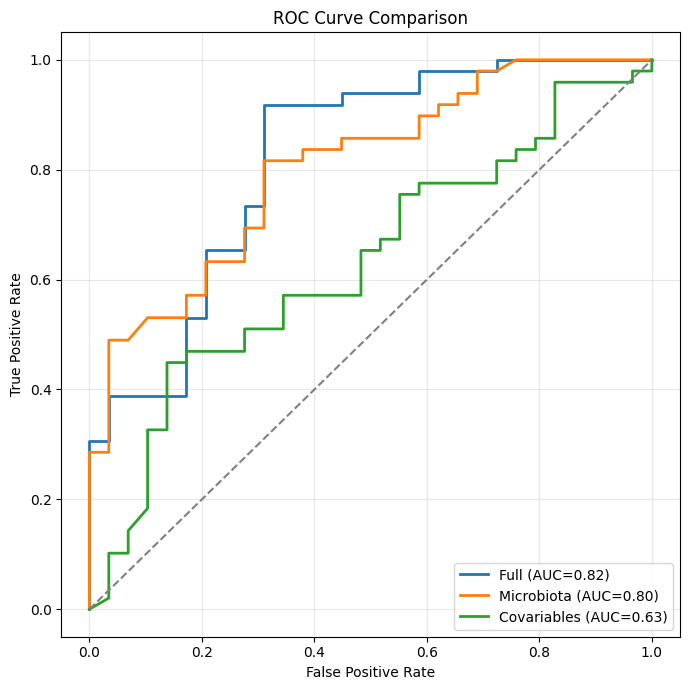

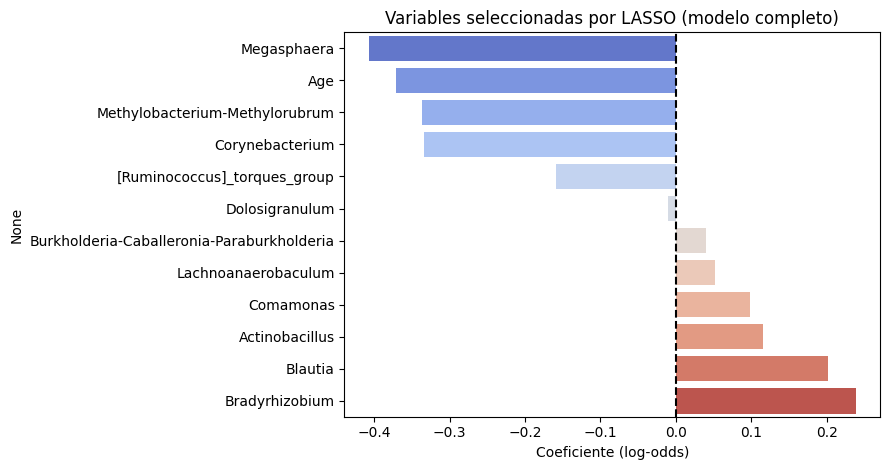

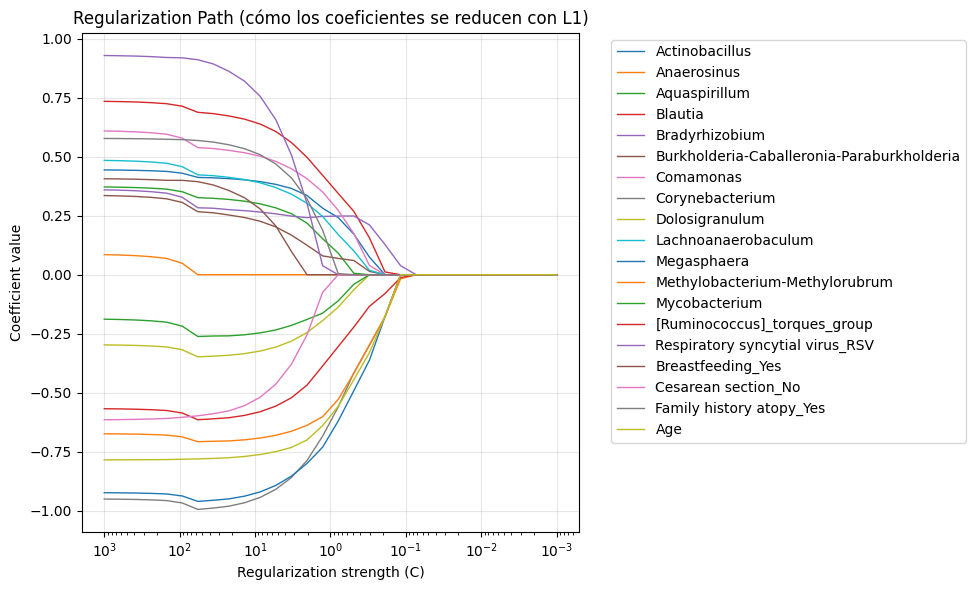

,Feature,Coef_mean,CI_lower,CI_upper,p_empirical
0,Megasphaera,-0.407073,-25.928992,0.003145,0.052
1,Age,-0.371454,-5.229855,-0.126010,0.028
2,Methylobacterium-Methylorubrum,-0.336972,-16.509609,0.253925,0.128
3,Corynebacterium,-0.333216,-9.124509,0.124932,0.080
4,[Ruminococcus]_torques_group,-0.159146,-6.250812,0.370317,0.152
5,Dolosigranulum,-0.009844,-4.072755,12.730186,0.472
6,Burkholderia-Caballeronia-Paraburkholderia,0.039253,-1.054917,7.033148,0.520
7,Lachnoanaerobaculum,0.051827,-1.258013,9.705676,0.470
8,Comamonas,0.097748,-0.513180,6.279782,0.252
9,Actinobacillus,0.114782,-3.888806,3.581854,0.502


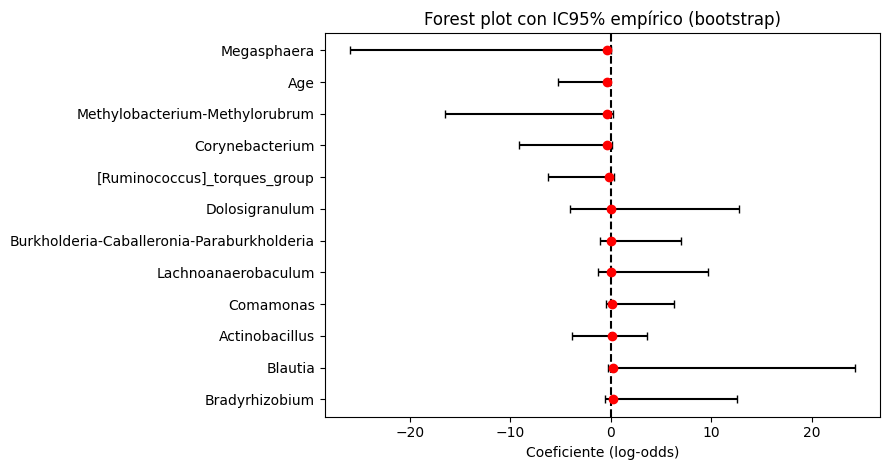

P-value global del modelo completo: 0.0013


In [ ]:

diff_abundances = pd.read_csv("/home/ucm-user/Documentos/BQL_ANALYSIS/Abundances/ANF_WHEEZING_ANCOMBC2.csv",index_col=0)

dif_genus = diff_abundances.loc[(abs(diff_abundances['lfc_Wheezing.treatmentYes'])>1) & (diff_abundances['q_Wheezing.treatmentYes'] <0.05) ].taxon.map(lambda x: x.split(":")[1] if x.split(":")[0]!="Family" else "")

sel_genus = dif_genus.loc[dif_genus!=""].tolist()

# Remove unidentified genus
sel_genus.remove("unidentified_Saccharimonadales")

# EXTRACT THE SIGNIFICANT GENUS AGREGGATED COUNTS
df_genus = pd.DataFrame(bql_anf_brq.adata.X[:,bql_anf_brq.adata.var.Genus.map(lambda x: x in sel_genus)],index=bql_anf_brq.adata.obs_names).T
df_genus["Genus"] = bql_anf_brq.adata.var.Genus[bql_anf_brq.adata.var.Genus.map(lambda x: x in sel_genus)].tolist()
df_genus = df_genus.groupby("Genus").sum().T

clr_genus = transform_to_clr(df_genus)
clr_genus.head()
# Preprocess
variables = []
cat_vars = ['Wheezing treatment','Respiratory syncytial virus','Breastfeeding', 'Cesarean section','Family history atopy']
for var in cat_vars:
    variable = bql_anf_brq.make_dummy(var).astype(int)
    variables.append(variable[variable.columns[0]])

categorical_covars = pd.concat(variables,axis=1)

covariables = pd.concat([categorical_covars,bql_anf_brq.adata.obs[['Age']]],axis=1)


X = pd.concat([clr_genus,covariables],axis=1).dropna()

y = X["Wheezing treatment_Wheezing"]

X = X.drop("Wheezing treatment_Wheezing",axis=1)

cont_vars = sel_genus+["Age"]
cont_data = X[X.columns[X.columns.isin(cont_vars)]]
cont_data_STD = StandardScaler().fit_transform(cont_data)
X[cont_vars] = cont_data_STD

# -----------------------------------------------------------
# 1. FUNCIÓN LASSO CON CV
# -----------------------------------------------------------
def fit_lasso_model(X_in, y):
    lasso = LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        class_weight='balanced',
        max_iter=5000,
        n_jobs=-1,
        random_state=42
    )
    lasso.fit(X_in, y)
    
    y_proba = lasso.predict_proba(X_in)[:, 1]
    auc = roc_auc_score(y, y_proba)
    
    return lasso, auc, y_proba

# -----------------------------------------------------------
# 2. ENTRENAR LOS 3 MODELOS
# -----------------------------------------------------------
covariate_cols = [c for c in X.columns if c not in sel_genus]

X_mic = X[sel_genus]
X_cov = X[covariate_cols]

lasso_full, auc_full, proba_full = fit_lasso_model(X, y)
lasso_mic,  auc_mic,  proba_mic  = fit_lasso_model(X_mic, y)
lasso_cov,  auc_cov,  proba_cov  = fit_lasso_model(X_cov, y)

print("AUC FULL model:", auc_full)
print("AUC MICROBIOTA ONLY:", auc_mic)
print("AUC COVARIABLES ONLY:", auc_cov)

# -----------------------------------------------------------
# 3. ROC CURVE COMPARATIVA
# -----------------------------------------------------------
plt.figure(figsize=(7,7))
for name, proba in zip(["Full", "Microbiota", "Covariables"],
                       [proba_full, proba_mic, proba_cov]):
    fpr, tpr, _ = roc_curve(y, proba)
    auc_val = roc_auc_score(y, proba)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 4. IMPORTANCIA DE VARIABLES (SOLO MODELO COMPLETO)
# -----------------------------------------------------------
coef = pd.Series(lasso_full.coef_[0], index=X.columns)
nonzero = coef[coef.abs() > 1e-5].sort_values()

plt.figure(figsize=(9, max(4, len(nonzero)*0.4)))
sns.barplot(x=nonzero.values, y=nonzero.index, palette='coolwarm')
plt.axvline(0, ls='--', color='black')
plt.title("Variables seleccionadas por LASSO (modelo completo)")
plt.xlabel("Coeficiente (log-odds)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 5. REGULARIZATION PATH (coef path plot)
# -----------------------------------------------------------
Cs = np.logspace(-3, 3, 30)  # distintos niveles de penalización
coefs = []

for C in Cs:
    lr = LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=5000,
        C=C
    )
    lr.fit(X, y)
    coefs.append(lr.coef_[0])

coefs = np.array(coefs)
plt.figure(figsize=(10,6))
for i, col in enumerate(X.columns):
    plt.plot(Cs, coefs[:,i], label=col, lw=1)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel("Regularization strength (C)")
plt.ylabel("Coefficient value")
plt.title("Regularization Path (cómo los coeficientes se reducen con L1)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 6. BOOTSTRAP PARA IC95% Y P-VALUES EMPÍRICOS
# -----------------------------------------------------------
n_boot = 1000
coef_matrix = np.zeros((n_boot, len(nonzero)))

X_sel = X[nonzero.index]

for i in range(n_boot):
    idx = np.random.choice(X_sel.index, size=len(X_sel), replace=True)
    X_boot = X_sel.loc[idx]
    y_boot = y.loc[idx]
    lr = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
    lr.fit(X_boot, y_boot)
    coef_matrix[i,:] = lr.coef_[0]

# IC95% empírico
ci_lower = np.percentile(coef_matrix, 2.5, axis=0)
ci_upper = np.percentile(coef_matrix, 97.5, axis=0)
p_empirical = np.mean((coef_matrix > 0).astype(int), axis=0)
p_empirical = 2 * np.minimum(p_empirical, 1-p_empirical)  # dos colas

df_boot = pd.DataFrame({
    "Feature": nonzero.index,
    "Coef_mean": nonzero.values,
    "CI_lower": ci_lower,
    "CI_upper": ci_upper,
    "p_empirical": p_empirical
})
display(df_boot)

# Forest plot bootstrap
plt.figure(figsize=(9, max(4, len(nonzero)*0.4)))
plt.errorbar(
    x=df_boot["Coef_mean"],
    y=np.arange(len(df_boot)),
    xerr=[df_boot["Coef_mean"] - df_boot["CI_lower"], df_boot["CI_upper"] - df_boot["Coef_mean"]],
    fmt='o',
    color='red',
    ecolor='black',
    capsize=3
)
plt.yticks(np.arange(len(df_boot)), df_boot["Feature"])
plt.axvline(0, ls='--', color='black')
plt.xlabel("Coeficiente (log-odds)")
plt.title("Forest plot con IC95% empírico (bootstrap)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 7. TEST GLOBAL DEL MODELO COMPLETO
# -----------------------------------------------------------
X_const = sm.add_constant(X_sel)
model_full_sm = sm.Logit(y, X_const).fit(disp=0)
ll_null = sm.Logit(y, np.ones((len(y),1))).fit(disp=0).llf
ll_full = model_full_sm.llf
LR_stat = 2 * (ll_full - ll_null)
from scipy.stats import chi2
p_value_global = chi2.sf(LR_stat, df=model_full_sm.df_model)
print(f"P-value global del modelo completo: {p_value_global:.4f}")


AUC FULL model: 0.7600281491907107
AUC MICROBIOTA ONLY: 0.7336382828993666
AUC COVARIABLES ONLY: 0.6301900070372977


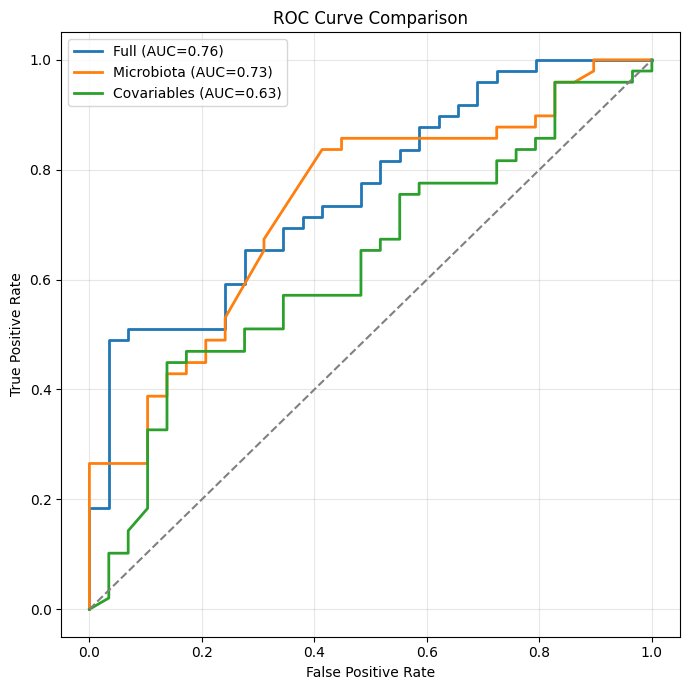

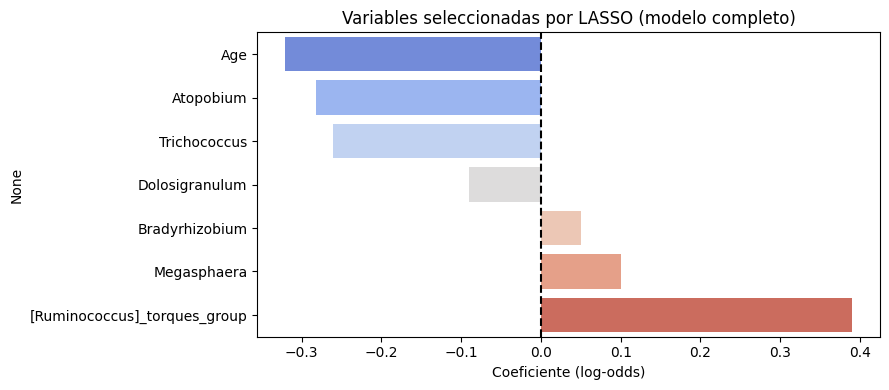

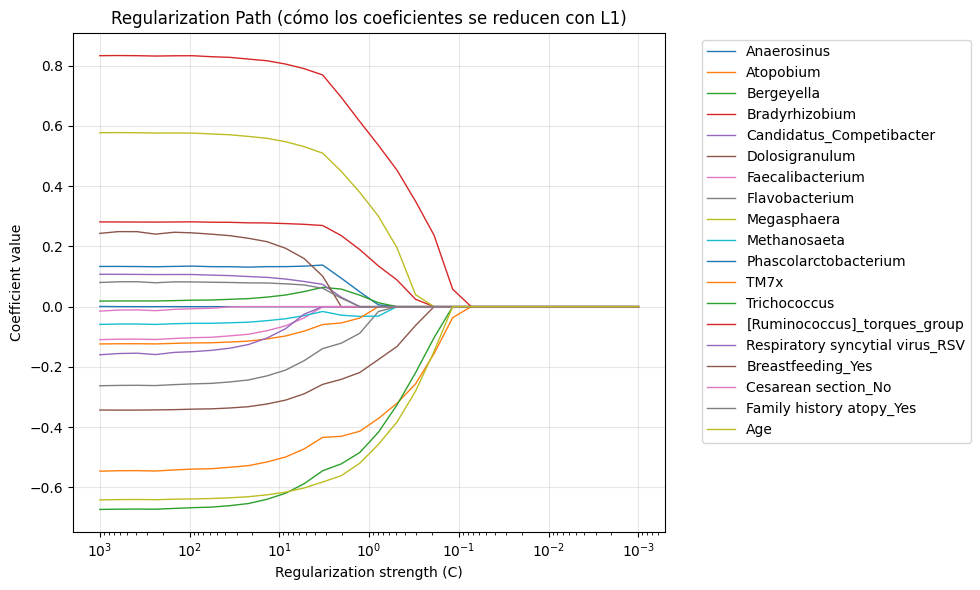

,Feature,Coef_mean,CI_lower,CI_upper,p_empirical
0,Age,-0.320303,-1.795467,-0.061826,0.036
1,Atopobium,-0.281446,-1.313998,0.190904,0.162
2,Trichococcus,-0.260353,-4.570885,0.159530,0.084
3,Dolosigranulum,-0.089665,-2.101695,1.393613,0.492
4,Bradyrhizobium,0.050028,-0.504281,1.504444,0.518
5,Megasphaera,0.100369,-0.387318,6.878318,0.188
6,[Ruminococcus]_torques_group,0.389617,0.092030,2.317670,0.028


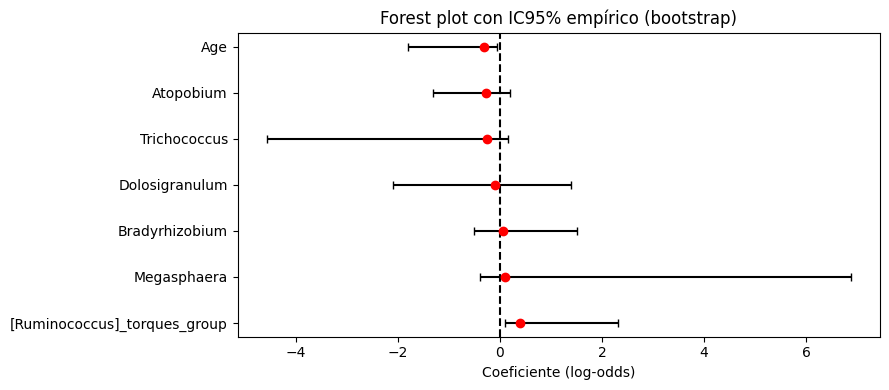

P-value global del modelo completo: 0.0079


In [ ]:
# Extract genus
diff_abundances = pd.read_csv("/home/ucm-user/Documentos/BQL_ANALYSIS/Abundances/ANF_WHEEZING_ANCOMBC2.csv",index_col=0)

dif_genus = diff_abundances.loc[(abs(diff_abundances['lfc_Respiratory.syncytial.virusYes'])>1) & (diff_abundances['q_Respiratory.syncytial.virusYes'] <0.05) ].taxon.map(lambda x: x.split(":")[1] if x.split(":")[0]!="Family" else "")

sel_genus = dif_genus.loc[dif_genus!=""].tolist()


# EXTRACT THE SIGNIFICANT GENUS AGREGGATED COUNTS
df_genus = pd.DataFrame(bql_anf_brq.adata.X[:,bql_anf_brq.adata.var.Genus.map(lambda x: x in sel_genus)],index=bql_anf_brq.adata.obs_names).T
df_genus["Genus"] = bql_anf_brq.adata.var.Genus[bql_anf_brq.adata.var.Genus.map(lambda x: x in sel_genus)].tolist()
df_genus = df_genus.groupby("Genus").sum().T

clr_genus = transform_to_clr(df_genus)
# Preprocess
variables = []
cat_vars = ['Wheezing treatment','Respiratory syncytial virus','Breastfeeding', 'Cesarean section','Family history atopy']
for var in cat_vars:
    variable = bql_anf_brq.make_dummy(var).astype(int)
    variables.append(variable[variable.columns[0]])

categorical_covars = pd.concat(variables,axis=1)

covariables = pd.concat([categorical_covars,bql_anf_brq.adata.obs[['Age']]],axis=1)


X = pd.concat([clr_genus,covariables],axis=1).dropna()

y = X["Wheezing treatment_Wheezing"]

X = X.drop("Wheezing treatment_Wheezing",axis=1)

cont_vars = sel_genus+["Age"]
cont_data = X[X.columns[X.columns.isin(cont_vars)]]
cont_data_STD = StandardScaler().fit_transform(cont_data)
X[cont_vars] = cont_data_STD

# -----------------------------------------------------------
# 1. FUNCIÓN LASSO CON CV
# -----------------------------------------------------------
def fit_lasso_model(X_in, y):
    lasso = LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        class_weight='balanced',
        max_iter=5000,
        n_jobs=-1,
        random_state=42
    )
    lasso.fit(X_in, y)
    
    y_proba = lasso.predict_proba(X_in)[:, 1]
    auc = roc_auc_score(y, y_proba)
    
    return lasso, auc, y_proba

# -----------------------------------------------------------
# 2. ENTRENAR LOS 3 MODELOS
# -----------------------------------------------------------
covariate_cols = [c for c in X.columns if c not in sel_genus]

X_mic = X[sel_genus]
X_cov = X[covariate_cols]

lasso_full, auc_full, proba_full = fit_lasso_model(X, y)
lasso_mic,  auc_mic,  proba_mic  = fit_lasso_model(X_mic, y)
lasso_cov,  auc_cov,  proba_cov  = fit_lasso_model(X_cov, y)

print("AUC FULL model:", auc_full)
print("AUC MICROBIOTA ONLY:", auc_mic)
print("AUC COVARIABLES ONLY:", auc_cov)

# ------------------------------------
# 3. ROC CURVE COMPARATIVA
# -----------------------------------------------------------
plt.figure(figsize=(7,7))
for name, proba in zip(["Full", "Microbiota", "Covariables"],
                       [proba_full, proba_mic, proba_cov]):
    fpr, tpr, _ = roc_curve(y, proba)
    auc_val = roc_auc_score(y, proba)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_val:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 4. IMPORTANCIA DE VARIABLES (SOLO MODELO COMPLETO)
# -----------------------------------------------------------
coef = pd.Series(lasso_full.coef_[0], index=X.columns)
nonzero = coef[coef.abs() > 1e-5].sort_values()

plt.figure(figsize=(9, max(4, len(nonzero)*0.4)))
sns.barplot(x=nonzero.values, y=nonzero.index, palette='coolwarm')
plt.axvline(0, ls='--', color='black')
plt.title("Variables seleccionadas por LASSO (modelo completo)")
plt.xlabel("Coeficiente (log-odds)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 5. REGULARIZATION PATH (coef path plot)
# -----------------------------------------------------------
Cs = np.logspace(-3, 3, 30)  # distintos niveles de penalización
coefs = []

for C in Cs:
    lr = LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=5000,
        C=C
    )
    lr.fit(X, y)
    coefs.append(lr.coef_[0])

coefs = np.array(coefs)
plt.figure(figsize=(10,6))
for i, col in enumerate(X.columns):
    plt.plot(Cs, coefs[:,i], label=col, lw=1)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel("Regularization strength (C)")
plt.ylabel("Coefficient value")
plt.title("Regularization Path (cómo los coeficientes se reducen con L1)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 6. BOOTSTRAP PARA IC95% Y P-VALUES EMPÍRICOS
# -----------------------------------------------------------
n_boot = 1000
coef_matrix = np.zeros((n_boot, len(nonzero)))

X_sel = X[nonzero.index]

for i in range(n_boot):
    idx = np.random.choice(X_sel.index, size=len(X_sel), replace=True)
    X_boot = X_sel.loc[idx]
    y_boot = y.loc[idx]
    lr = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
    lr.fit(X_boot, y_boot)
    coef_matrix[i,:] = lr.coef_[0]

# IC95% empírico
ci_lower = np.percentile(coef_matrix, 2.5, axis=0)
ci_upper = np.percentile(coef_matrix, 97.5, axis=0)
p_empirical = np.mean((coef_matrix > 0).astype(int), axis=0)
p_empirical = 2 * np.minimum(p_empirical, 1-p_empirical)  # dos colas

df_boot = pd.DataFrame({
    "Feature": nonzero.index,
    "Coef_mean": nonzero.values,
    "CI_lower": ci_lower,
    "CI_upper": ci_upper,
    "p_empirical": p_empirical
})
display(df_boot)

# Forest plot bootstrap
plt.figure(figsize=(9, max(4, len(nonzero)*0.4)))
plt.errorbar(
    x=df_boot["Coef_mean"],
    y=np.arange(len(df_boot)),
    xerr=[df_boot["Coef_mean"] - df_boot["CI_lower"], df_boot["CI_upper"] - df_boot["Coef_mean"]],
    fmt='o',
    color='red',
    ecolor='black',
    capsize=3
)
plt.yticks(np.arange(len(df_boot)), df_boot["Feature"])
plt.axvline(0, ls='--', color='black')
plt.xlabel("Coeficiente (log-odds)")
plt.title("Forest plot con IC95% empírico (bootstrap)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 7. TEST GLOBAL DEL MODELO COMPLETO
# -----------------------------------------------------------
X_const = sm.add_constant(X_sel)
model_full_sm = sm.Logit(y, X_const).fit(disp=0)
ll_null = sm.Logit(y, np.ones((len(y),1))).fit(disp=0).llf
ll_full = model_full_sm.llf
LR_stat = 2 * (ll_full - ll_null)
from scipy.stats import chi2
p_value_global = chi2.sf(LR_stat, df=model_full_sm.df_model)
print(f"P-value global del modelo completo: {p_value_global:.4f}")


#  PREPROCESS DATA FOR WGCNA:

- Metadata variables were codified into numeric binary categories for the WGCNA analysis.

- The rarefied count data was normalized by the centered log ratio method


OOF AUC - Full: 0.540, Microbiota: 0.489, Covariables: 0.598

NRI Full vs Covariates-only:
{'nri': np.float64(-0.014074595355383523), 'nri_events': np.float64(0.020408163265306145), 'nri_nonevents': np.float64(-0.03448275862068967), 'up_event_prop': np.float64(0.5102040816326531), 'down_event_prop': np.float64(0.4897959183673469), 'up_nonevent_prop': np.float64(0.5172413793103449), 'down_nonevent_prop': np.float64(0.4827586206896552)}
Bootstrap mean NRI: -0.0199, 95% CI: [-0.4918, 0.4760], p=0.9400

NRI Full vs Microbiota-only:
{'nri': np.float64(0.2997888810696693), 'nri_events': np.float64(0.2653061224489796), 'nri_nonevents': np.float64(0.03448275862068967), 'up_event_prop': np.float64(0.6326530612244898), 'down_event_prop': np.float64(0.3673469387755102), 'up_nonevent_prop': np.float64(0.4827586206896552), 'down_nonevent_prop': np.float64(0.5172413793103449)}
Bootstrap mean NRI: 0.2990, 95% CI: [-0.1617, 0.7349], p=0.1870


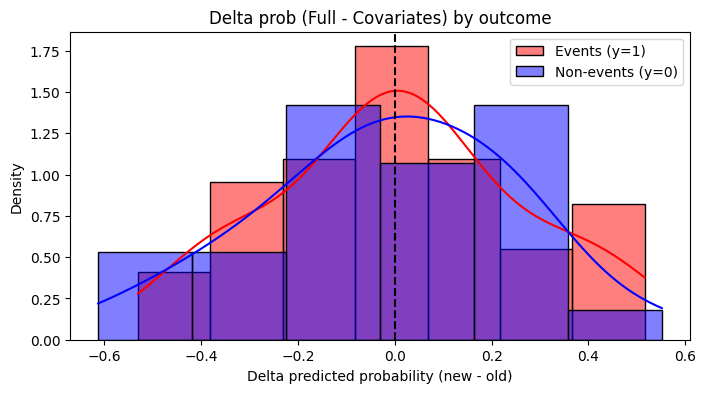

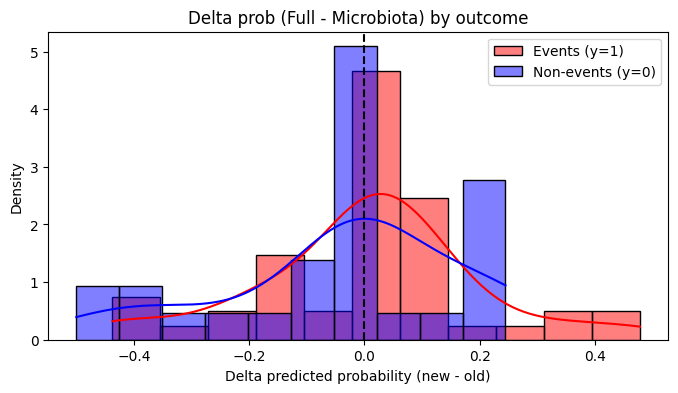


Reclassification table Full vs Covariance:
{'events_up': np.int64(25), 'events_down': np.int64(24), 'events_eq': np.int64(0), 'ne_up': np.int64(15), 'ne_down': np.int64(14), 'ne_eq': np.int64(0)}

Reclassification table Full vs Microbiota:
{'events_up': np.int64(31), 'events_down': np.int64(18), 'events_eq': np.int64(0), 'ne_up': np.int64(14), 'ne_down': np.int64(15), 'ne_eq': np.int64(0)}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve

variables = []
cat_vars = ['Wheezing treatment','Respiratory syncytial virus','Breastfeeding', 'Cesarean section','Family history atopy']
for var in cat_vars:
    variable = bql_anf_brq.make_dummy(var).astype(int)
    variables.append(variable[variable.columns[0]])

categorical_covars = pd.concat(variables,axis=1)

covariables = pd.concat([categorical_covars,bql_anf_brq.adata.obs[['Age']]],axis=1)


X = pd.concat([clr_genus,covariables],axis=1).dropna()

y = X["Wheezing treatment_Wheezing"]

X = X.drop("Wheezing treatment_Wheezing",axis=1)

# -------------------------
# 1) Función para obtener OOF predicted probabilities
#    Entrena dentro de cada fold un LogisticRegressionCV (o LogisticRegression) y devuelve
#    un array de probabilidades out-of-fold (una pred por muestra usando fold donde fue test)
# -------------------------
def get_oof_proba(X, y, estimator_builder, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)):
    """
    X: DataFrame
    y: Series (0/1)
    estimator_builder: callable(void) -> estimator (fresh instance)
    cv: cross-validator
    returns: oof_proba: numpy array shape (n_samples,)
    """
    n = X.shape[0]
    oof = np.zeros(n, dtype=float)
    for train_idx, test_idx in cv.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr = y.iloc[train_idx]
        est = estimator_builder()
        est.fit(X_tr, y_tr)
        oof[test_idx] = est.predict_proba(X_te)[:, 1]
    return oof

# -------------------------
# 2) Construir estimadores (builder functions)
#    Usamos LogisticRegressionCV for internal tuning but could use simple LR with chosen C.
# -------------------------
def build_lasso_cv():
    return LogisticRegressionCV(
        penalty='l1',
        solver='saga',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
        scoring='roc_auc',
        class_weight='balanced',
        max_iter=5000,
        n_jobs=1,       # inside outer CV we don't parallelize to avoid oversubscription
        random_state=0
    )

def build_lasso_fixed(C=1.0):
    return LogisticRegression(
        penalty='l1',
        C=C,
        solver='saga',
        class_weight='balanced',
        max_iter=5000,
        random_state=0
    )

# -------------------------
# 3) Obtener OOF probabilidades para los 3 modelos
# -------------------------
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model builders use nested CV inside folds (LogisticRegressionCV) to choose C robustly
oof_full = get_oof_proba(X, y, estimator_builder=build_lasso_cv, cv=cv_outer)
oof_micro = get_oof_proba(X[sel_genus], y, estimator_builder=build_lasso_cv, cv=cv_outer)
oof_cov  = get_oof_proba(X[covariate_cols], y, estimator_builder=build_lasso_cv, cv=cv_outer)

# Quick AUCs (OOF)
auc_full = roc_auc_score(y, oof_full)
auc_micro = roc_auc_score(y, oof_micro)
auc_cov = roc_auc_score(y, oof_cov)
print(f"OOF AUC - Full: {auc_full:.3f}, Microbiota: {auc_micro:.3f}, Covariables: {auc_cov:.3f}")

# -------------------------
# 4) NRI (continuous) implementation
#    For two arrays of predicted probabilities: p_old (baseline), p_new (candidate)
# -------------------------
def nri_continuous(y_true, p_old, p_new):
    """
    Compute continuous NRI (pairwise):
    NRI = [P(up|event) - P(down|event)] + [P(down|non-event) - P(up|non-event)]
    where "up" means p_new > p_old and "down" p_new < p_old.
    Returns dictionary with components.
    """
    y_true = np.asarray(y_true)
    p_old = np.asarray(p_old)
    p_new = np.asarray(p_new)
    delta = p_new - p_old

    event_idx = (y_true == 1)
    non_event_idx = (y_true == 0)

    # events
    up_e = np.sum(delta[event_idx] > 0) / max(1, np.sum(event_idx))
    down_e = np.sum(delta[event_idx] < 0) / max(1, np.sum(event_idx))
    # non-events
    up_ne = np.sum(delta[non_event_idx] > 0) / max(1, np.sum(non_event_idx))
    down_ne = np.sum(delta[non_event_idx] < 0) / max(1, np.sum(non_event_idx))

    nri_events = up_e - down_e
    nri_nonevents = down_ne - up_ne
    nri_total = nri_events + nri_nonevents

    return {
        'nri': nri_total,
        'nri_events': nri_events,
        'nri_nonevents': nri_nonevents,
        'up_event_prop': up_e,
        'down_event_prop': down_e,
        'up_nonevent_prop': up_ne,
        'down_nonevent_prop': down_ne
    }

# -------------------------
# 5) Bootstrap for CI and p-value
#    We bootstrap subjects with replacement using OOF predicted probs (no refit).
#    This provides uncertainty for NRI estimate across subjects.
# -------------------------
def bootstrap_nri(y_true, p_old, p_new, n_boot=2000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    nri_boot = []
    for i in range(n_boot):
        idx = rng.integers(0, n, n)  # sample with replacement
        sample_nri = nri_continuous(y_true[idx], p_old[idx], p_new[idx])['nri']
        nri_boot.append(sample_nri)
    nri_boot = np.array(nri_boot)
    lower = np.percentile(nri_boot, 2.5)
    upper = np.percentile(nri_boot, 97.5)
    pval = 2 * min((np.sum(nri_boot <= 0) / n_boot), (np.sum(nri_boot >= 0) / n_boot))  # two-sided
    return nri_boot.mean(), (lower, upper), pval, nri_boot

# -------------------------
# 6) Compute NRI: Full vs Covariates; Full vs Microbiota
# -------------------------
print("\nNRI Full vs Covariates-only:")
nri_res_fc = nri_continuous(y, oof_cov, oof_full)
nri_mean_fc, nri_ci_fc, nri_p_fc, nri_boot_fc = bootstrap_nri(y.values, oof_cov, oof_full, n_boot=2000, seed=1)
print(nri_res_fc)
print(f"Bootstrap mean NRI: {nri_mean_fc:.4f}, 95% CI: [{nri_ci_fc[0]:.4f}, {nri_ci_fc[1]:.4f}], p={nri_p_fc:.4f}")

print("\nNRI Full vs Microbiota-only:")
nri_res_fm = nri_continuous(y, oof_micro, oof_full)
nri_mean_fm, nri_ci_fm, nri_p_fm, nri_boot_fm = bootstrap_nri(y.values, oof_micro, oof_full, n_boot=2000, seed=2)
print(nri_res_fm)
print(f"Bootstrap mean NRI: {nri_mean_fm:.4f}, 95% CI: [{nri_ci_fm[0]:.4f}, {nri_ci_fm[1]:.4f}], p={nri_p_fm:.4f}")

# -------------------------
# 7) Plots: distribution of delta p (full - base) for events/non-events
# -------------------------
def plot_delta_hist(y_true, p_old, p_new, title):
    delta = p_new - p_old
    df = pd.DataFrame({'delta': delta, 'y': y_true})
    plt.figure(figsize=(8,4))
    sns.histplot(data=df[df['y']==1], x='delta', label='Events (y=1)', kde=True, stat='density', color='red', alpha=0.5)
    sns.histplot(data=df[df['y']==0], x='delta', label='Non-events (y=0)', kde=True, stat='density', color='blue', alpha=0.5)
    plt.axvline(0, color='k', linestyle='--')
    plt.legend()
    plt.title(title)
    plt.xlabel('Delta predicted probability (new - old)')
    plt.show()

plot_delta_hist(y, oof_cov, oof_full, "Delta prob (Full - Covariates) by outcome")
plot_delta_hist(y, oof_micro, oof_full, "Delta prob (Full - Microbiota) by outcome")

# -------------------------
# 8) Reclassification tables (counts)
#    Count up/down for events and non-events
# -------------------------
def reclassification_table(y_true, p_old, p_new):
    delta = p_new - p_old
    up = delta > 0
    down = delta < 0
    eq = delta == 0

    events = y_true==1
    non_events = y_true==0

    tab = {
        'events_up': np.sum(up & events),
        'events_down': np.sum(down & events),
        'events_eq': np.sum(eq & events),
        'ne_up': np.sum(up & non_events),
        'ne_down': np.sum(down & non_events),
        'ne_eq': np.sum(eq & non_events),
    }
    return tab

print("\nReclassification table Full vs Covariance:")
print(reclassification_table(y.values, oof_cov, oof_full))

print("\nReclassification table Full vs Microbiota:")
print(reclassification_table(y.values, oof_micro, oof_full))

# -------------------------
# 9) Optional: save bootstrap arrays for further plotting or reporting
# -------------------------
# np.save("nri_boot_fc.npy", nri_boot_fc)
# np.save("nri_boot_fm.npy", nri_boot_fm)


In [ ]:
os.makedirs("WGCNA",exist_ok=True)
os.makedirs("WGCNA/data",exist_ok=True)

# Formatting and saving ANF data
meta_anf = bql_anf.adata.obs[["Bronchiolitis",	
                  'Wheezing treatment',	
                  'Respiratory syncytial virus',	
                  'Cesarean section',
                  'Previous antibiotics',
                  'Age_older',
                  'Family history atopy',
                  'Breastfeeding']].replace({"Yes":1,
                                             "No":0,
                                             "Bronchiolitis":1,
                                             "Control":0}).dropna()
meta_anf.to_csv("WGCNA/data/ANF_BQL_metadata.csv")


# Formatting and saving GUT data
meta_gut = bql_gut.adata.obs[["Bronchiolitis",	
                  'Wheezing treatment',	
                  'Respiratory syncytial virus',	
                  'Cesarean section',
                  'Previous antibiotics',
                  'Age_older',
                  'Family history atopy',
                  'Breastfeeding']].replace({"Yes":1,
                                             "No":0,
                                             "Bronchiolitis":1,
                                             "Control":0}).dropna()
meta_gut.to_csv("WGCNA/data/GUT_BQL_metadata.csv")

### COUNT DATA NORMALIZING

In [ ]:
# Extract the rarefied data
df_anf = bql_anf.adata.to_df().loc[meta_anf.index]

# Add the genus label
df_anf.loc["Genus"] = bql_anf.adata.var.Genus

# Aggregate the data by Genus
df_anf = df_anf.T.dropna(subset="Genus").groupby("Genus").sum().T

# Filter out the unassigned genus
df_anf = df_anf[df_anf.columns[df_anf.columns.str.contains("unidentif")==False]].T


# This column selects those taxa that appears in at leat th 5% of the samples (will be relevat for networks) 5
df_anf["MIN_SAMPLE_CRITERIA"] = [(df_anf.loc[ind]>0).sum()>5 for ind in df_anf.index]
# This column selects taxa with an abundance above the 10% quantile along all samples
df_anf["Min_Counts_criteria"] = df_anf.sum(axis=1)>df_anf.sum(axis=1).quantile(0.1)
# Filter and transpose the data
df_anf = df_anf[(df_anf.Min_Counts_criteria)&(df_anf.MIN_SAMPLE_CRITERIA)].drop(["MIN_SAMPLE_CRITERIA","Min_Counts_criteria"],axis=1).T

# Apply CLR normalization
clr_transformed = transform_to_clr(df_anf)

clr_transformed.to_csv("WGCNA/data/ANF_BQL_counts.csv")

clr_transformed

Genus,Acetoanaerobium,Acetobacteroides,Acidibacter,Acidovorax,Acinetobacter,Actinobacillus,Actinomyces,Aeromonas,Agathobacter,Aggregatibacter,...,Treponema,Trichococcus,UCG-005,Uruburuella,Veillonella,Zoogloea,[Eubacterium]_hallii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,dgA-11_gut_group
BQLHLP100ANF,4.107680,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,...,-1.196871,-1.196871,-1.196871,-1.196871,8.640714,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871
BQLHLP101ANF,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,...,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877
BQLHLP103ANF,-1.795517,-1.795517,-1.795517,-1.795517,-1.795517,-1.795517,10.507877,-1.795517,-1.795517,-1.795517,...,-1.795517,4.430377,2.828818,-1.795517,9.429669,-1.795517,-1.795517,-1.795517,2.828818,-1.795517
BQLHLP104ANF,-1.514088,-1.514088,-1.514088,4.806125,4.806125,-1.514088,10.904647,-1.514088,-1.514088,-1.514088,...,-1.514088,-1.514088,-1.514088,-1.514088,11.202922,-1.514088,-1.514088,-1.514088,-1.514088,-1.514088
BQLHLP105ANF,0.957770,-4.757572,-4.757572,3.075130,3.845025,-4.757572,3.863371,2.900852,1.649268,-4.757572,...,0.957770,3.439652,1.244628,-4.757572,5.572918,0.553951,0.957770,0.957770,1.244628,1.803183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HULP67ANF,2.941677,-3.865873,1.845273,3.452060,4.407163,-3.865873,-3.865873,3.142147,2.132128,-3.865873,...,-3.865873,3.921815,1.441461,1.845273,2.132128,-3.865873,-3.865873,-3.865873,0.753257,2.132128
HULP68ANF,-4.463793,-4.463793,2.798925,3.625209,4.938372,-4.463793,2.462733,3.378435,-4.463793,-4.463793,...,3.104122,4.601933,2.106478,2.357481,2.462733,2.106478,-4.463793,-4.463793,1.770567,2.106478
HULP69ANF,-1.624416,-1.624416,4.377712,-1.624416,-1.624416,5.985169,-1.624416,-1.624416,-1.624416,-1.624416,...,2.998811,-1.624416,-1.624416,-1.624416,6.652757,-1.624416,-1.624416,-1.624416,-1.624416,-1.624416
HULP70ANF,1.971955,-3.340646,4.962993,4.107662,5.704801,2.375775,1.283724,3.472191,2.885284,-3.340646,...,2.885284,-3.340646,2.662634,-3.340646,-3.340646,2.662634,1.971955,-3.340646,-3.340646,2.375775


## Now the BQL GUT data

In [ ]:
# Extract the rarefied data
df_gut = bql_gut.adata.to_df().loc[meta_gut.index]

# Add the genus label
df_gut.loc["Genus"] = bql_gut.adata.var.Genus

# Aggregate the data by Genus
df_gut = df_gut.T.dropna(subset="Genus").groupby("Genus").sum().T

# Filter out the unassigned genus
df_gut = df_gut[df_gut.columns[df_gut.columns.str.contains("unidentif")==False]].T


# This column selects those taxa that appears in at leat th 5% of the samples (will be relevat for networks)
df_gut["MIN_SAMPLE_CRITERIA"] = [(df_gut.loc[ind]>0).sum()>4 for ind in df_gut.index]
# This column selects taxa with an abundance above the 10% quantile along all samples
df_gut["Min_Counts_criteria"] = df_gut.sum(axis=1)>df_gut.sum(axis=1).quantile(0.1)
# Filter and transpose the data
df_gut = df_gut[(df_gut.Min_Counts_criteria)&(df_gut.MIN_SAMPLE_CRITERIA)].drop(["MIN_SAMPLE_CRITERIA","Min_Counts_criteria"],axis=1).T


# Apply CLR normalization
clr_transformed = transform_to_clr(df_anf)

clr_transformed.to_csv("WGCNA/data/GUT_BQL_counts.csv")

clr_transformed

Genus,Acetoanaerobium,Acetobacteroides,Acidibacter,Acidovorax,Acinetobacter,Actinobacillus,Actinomyces,Aeromonas,Agathobacter,Aggregatibacter,...,Treponema,Trichococcus,UCG-005,Uruburuella,Veillonella,Zoogloea,[Eubacterium]_hallii_group,[Ruminococcus]_gnavus_group,[Ruminococcus]_torques_group,dgA-11_gut_group
BQLHLP100ANF,4.107680,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871,...,-1.196871,-1.196871,-1.196871,-1.196871,8.640714,-1.196871,-1.196871,-1.196871,-1.196871,-1.196871
BQLHLP101ANF,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,...,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877,-0.469877
BQLHLP103ANF,-1.795517,-1.795517,-1.795517,-1.795517,-1.795517,-1.795517,10.507877,-1.795517,-1.795517,-1.795517,...,-1.795517,4.430377,2.828818,-1.795517,9.429669,-1.795517,-1.795517,-1.795517,2.828818,-1.795517
BQLHLP104ANF,-1.514088,-1.514088,-1.514088,4.806125,4.806125,-1.514088,10.904647,-1.514088,-1.514088,-1.514088,...,-1.514088,-1.514088,-1.514088,-1.514088,11.202922,-1.514088,-1.514088,-1.514088,-1.514088,-1.514088
BQLHLP105ANF,0.957770,-4.757572,-4.757572,3.075130,3.845025,-4.757572,3.863371,2.900852,1.649268,-4.757572,...,0.957770,3.439652,1.244628,-4.757572,5.572918,0.553951,0.957770,0.957770,1.244628,1.803183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HULP67ANF,2.941677,-3.865873,1.845273,3.452060,4.407163,-3.865873,-3.865873,3.142147,2.132128,-3.865873,...,-3.865873,3.921815,1.441461,1.845273,2.132128,-3.865873,-3.865873,-3.865873,0.753257,2.132128
HULP68ANF,-4.463793,-4.463793,2.798925,3.625209,4.938372,-4.463793,2.462733,3.378435,-4.463793,-4.463793,...,3.104122,4.601933,2.106478,2.357481,2.462733,2.106478,-4.463793,-4.463793,1.770567,2.106478
HULP69ANF,-1.624416,-1.624416,4.377712,-1.624416,-1.624416,5.985169,-1.624416,-1.624416,-1.624416,-1.624416,...,2.998811,-1.624416,-1.624416,-1.624416,6.652757,-1.624416,-1.624416,-1.624416,-1.624416,-1.624416
HULP70ANF,1.971955,-3.340646,4.962993,4.107662,5.704801,2.375775,1.283724,3.472191,2.885284,-3.340646,...,2.885284,-3.340646,2.662634,-3.340646,-3.340646,2.662634,1.971955,-3.340646,-3.340646,2.375775
